# Load libraries

In [2]:
pip install fastparquet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.9 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np 
import pandas as pd
import random
import os
import json
import ast
# import sweetviz as sw
from ydata_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFECV
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import roc_auc_score, make_scorer, fbeta_score, roc_curve, classification_report, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve
from scipy.stats import yeojohnson
import scikitplot as skplt
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, MinMaxScaler, StandardScaler
import time
from datetime import datetime
import pickle
import warnings


import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.subplots as sp
import plotly.graph_objs as go

seed = 42

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/churn-train-fe/train_fe.parquet
/kaggle/input/data-for-tests/features_SHAP_xgb_110f_89_700_auc_with_description.xlsx
/kaggle/input/data-for-tests/feature_importance_xgb_89_700_20072024.xlsx
/kaggle/input/bdl5-final-project/all_features_importance.xlsx
/kaggle/input/bdl5-final-project/Data_description.xlsx
/kaggle/input/bdl5-final-project/train_dpi.parquet
/kaggle/input/bdl5-final-project/train_fe_after_EDA_578_cyber_amg_apps.parquet
/kaggle/input/bdl5-final-project/test_bnum.parquet
/kaggle/input/bdl5-final-project/train_fe_after_EDA.parquet
/kaggle/input/bdl5-final-project/test_fe.parquet
/kaggle/input/bdl5-final-project/test_dpi.parquet
/kaggle/input/bdl5-final-project/final_features_set.xlsx
/kaggle/input/bdl5-final-project/test_fe_after_EDA_591_cyber_amg_apps_clustered_mis-1.parquet
/kaggle/input/bdl5-final-project/test_fe_after_EDA_551_cyber_amc.parquet
/kaggle/input/bdl5-final-project/train_fe_after_EDA_591_cyber_amg_apps_clustered_mis-1.parquet
/kaggle/input/bdl5-f

### Block with functions

In [4]:
# Function to return name of variable
def get_var_name(var):
    return [name for name in globals() if globals()[name] is var][0]

# Function to remove rows with a lot of missing values
def del_rows_wh_missing_val (dframe, threshold):    
    # Calculate the percentage of missing values in each row
    missing_values_by_rows = dframe.isna().mean(axis=1) * 100
    rows_with_high_missing = missing_values_by_rows[missing_values_by_rows > threshold]
    if not rows_with_high_missing.empty:
        print(f'Percentage of missing values more then {threshold}% in each row:\n', 
              rows_with_high_missing)
        return dframe.drop(index=rows_with_high_missing.index, inplace = True)
    else:
        print(f'There are no rows with percentage of missing values more than {threshold}%')
        return dframe.shape
    
# Function to find collumns name with missings more than threshold
def cols_wh_high_missing_val (dframe, threshold):
    missing_threshold = threshold
    missing_percent_in_col = dframe.isna().mean()*100
    columns_with_high_missings = missing_percent_in_col[missing_percent_in_col > missing_threshold].round(2).sort_values(ascending=False)
#     print(f'Initial columns with missing values more than {threshold}% in {get_var_name(dframe)} are {len(columns_with_high_missings)} \n', columns_with_high_missings)
    return columns_with_high_missings

# Function to make data frame for columns with missings in 2 dataframes: missings in % and # of unique values
def frames_with_missings (dframe, df_target, threshold):
    columns_with_missings = cols_wh_high_missing_val (dframe, threshold)
    columns_target_with_missings = cols_wh_high_missing_val (df_target, threshold)
    
    unique_values_main_df = dframe[columns_with_missings.index].nunique()
    unique_values_target_1_df = df_target[columns_target_with_missings.index].nunique()
    
    merged_miss_columns = pd.concat([columns_with_missings, columns_target_with_missings, unique_values_main_df, unique_values_target_1_df], axis=1)
    merged_miss_columns.columns = [f'{get_var_name(dframe)}, missings %', f'{get_var_name(df_target)}, missings %', f'{get_var_name(dframe)} # Unique Values', f'{get_var_name(df_target)} # Unique Values']
    
    return merged_miss_columns

#Function for receiving df of sorted features by importance
def features_importance (df, model):
    features=pd.DataFrame()
    features['columns']=df.columns
    features['importances'] = model.feature_importances_
    features.sort_values(by='importances',ascending=False,inplace=True)
    features.set_index('columns', inplace=True)
    features = features[features['importances']>0]
    features['cumulative_importance'] = features['importances'].cumsum()
    return features

# Function for receiving df of sorted SHAP values
def sorted_SHAP_values (shap_values, df):
    shap_mean_abs = pd.DataFrame(abs(shap_values).mean(0), index=df.columns, columns=['SHAP Value'])
    shap_mean_abs = shap_mean_abs.sort_values(by='SHAP Value', ascending=False)
    shap_mean_abs = shap_mean_abs[shap_mean_abs['SHAP Value']>0]
    shap_mean_abs.rename(columns={'SHAP Value': 'importances'}, inplace=True)
    shap_mean_abs['cumulative_importance'] = shap_mean_abs['importances'].cumsum()
    return shap_mean_abs

# Custom metric for evaluate AUC difference between score on total train set and 
# score of one CV fold 
def auc_difference(estimator, X, y):
    # Receive prediction for training set
    y_train_pred = estimator.predict_proba(X)[:, 1]
    train_auc = roc_auc_score(y, y_train_pred)
    
    # Use validation set (eval_set) from model's params
    eval_set = estimator.evals_result_['valid_0']['auc']
    val_auc = eval_set[-1]
    
    # Return AUC difference (with '-' to minimize on CV)
    return -np.abs(train_auc - val_auc)

# Function to evaluate time for model training and prediction
def model_timing (model,train_data, y_train, test_data, iterations):
    start_time = time.time()
    formatted_time = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
    print(f'Stats timing test at: {formatted_time}')
    
    fitting_time = []
    prediction_time = []
    for i in range (0,iterations):
    
    #     Evaluate fitting time
        start_time_fit = time.time()
    
        model.fit(train_data, y_train)

        end_time_fit =time.time()
    
        one_fit_time = end_time_fit - start_time_fit
        fitting_time.append(one_fit_time)
    
        #     Evaluate prediction time
    
        start_time_pred = time.time()
    
        model.predict_proba(test_data)[:, 1]

        end_time_pred =time.time()
    
        one_pred_time = end_time_pred - start_time_pred
        prediction_time.append(one_pred_time)
    
        print(f'Iteration {i} done')

    end_time =time.time()
    print(f'Execution time: {end_time-start_time} seconds')
    
    print(f'Середній час навчання моделі {round(np.mean(fitting_time),3)} секунд')
    print(f'Середній час прогнозування моделлю {round(np.mean(prediction_time),3)} секунд')
    return [round(np.mean(fitting_time),3), round(np.mean(prediction_time),3)]

In [ ]:
# Information about CPU and RAM
!lscpu
!free -h

# Load data

In [ ]:
path_to_train_fe = '/kaggle/input/churn-train-fe/train_fe.parquet'
path_to_test_fe = '/kaggle/input/bdl5-final-project/test_fe.parquet'

train_fe = pd.read_parquet(path_to_train_fe, engine='fastparquet')
test_fe = pd.read_parquet(path_to_test_fe, engine='fastparquet')

train_fe.set_index('abon_id', inplace=True)
test_fe.set_index('abon_id', inplace=True)

train_fe.head()

In [ ]:
# Quantity of numerical features
len(train_fe.select_dtypes(include=['int64', 'float64']).columns)

In [ ]:
# Quantity of categorical features
len(train_fe.select_dtypes(include=['object', 'category']).columns)

In [ ]:
# Load data description
train_fe_desc = pd.read_excel(r"/kaggle/input/bdl5-final-project/Data_description.xlsx", sheet_name="MODEL_FE")
train_fe_desc = train_fe_desc.iloc[:,:3]
train_fe_desc.set_index('Feature Name (For participants)', inplace=True)
train_fe_desc

In [ ]:
train_fe_desc

### Look at 'target' balancing

In [ ]:
train_fe.target.value_counts()[0]/train_fe.target.value_counts()[1]

In [ ]:
test_fe.target.value_counts()[0]/test_fe.target.value_counts()[1]

# Missings and constants

## Drop rows and columns with high missings

In [ ]:
del_rows_wh_missing_val(train_fe, 80)
del_rows_wh_missing_val(test_fe, 80)

In [ ]:
cols_wh_high_missing_val(train_fe, 40)

In [ ]:
cols_wh_high_missing_val(test_fe, 40)

In [ ]:
if set(cols_wh_high_missing_val(train_fe, 0).index).issubset(set(cols_wh_high_missing_val(test_fe, 0).index)):
    print('Train and test sets have same columns with missings!')

In [ ]:
col_to_drop = set(cols_wh_high_missing_val(train_fe, 40).index) | set(cols_wh_high_missing_val(test_fe, 40).index)
len(col_to_drop)

In [ ]:
# Show distribution of selected columns with high % of missing values

# missing_values = train_fe[cols_wh_high_missing_val(train_fe, 40).index].isnull().sum().reset_index()
missing_values = pd.DataFrame(cols_wh_high_missing_val(train_fe, 40)).reset_index()
missing_values.columns = ['Feature', 'Missing_values']


plt.figure(figsize=(20, 6))
sns.barplot(x='Feature', y='Missing_values', data=missing_values, palette='viridis')
# plt.bar(missing_values.iloc[:, 0].values, missing_values['Missing_values'].values, color='skyblue')
plt.xlabel('Features', fontweight='bold')
plt.ylabel('Missing_values_%', fontweight='bold')
plt.xticks(range(len(missing_values)), [str(p) for p in missing_values['Feature'].values], rotation=45, ha='right')
plt.title('Distribution of features with high % of missing values', fontweight='bold', fontsize = 14)
plt.show()

In [ ]:
train_fe.drop(columns=col_to_drop, inplace = True)
test_fe.drop(columns=col_to_drop, inplace = True)

print(train_fe.shape, test_fe.shape)

## Remove columns with very high one value distribution

In [ ]:
# Find columns with main class value more than 90% in all column values
# and in target column, where 'target' == 1 exclude missings

target_1_frame = train_fe[train_fe['target']==1].copy()
rows = []
# total_count = train_fe.shape[0]

for col in train_fe.columns:
    
    value_counts = train_fe[col].value_counts()
#     value_counts = train_fe[col].value_counts(dropna = False)
    # Find most frequent value and it distribution
    main_class = value_counts.idxmax()
    most_frequent_count = value_counts.max()
    
    # Total values quantity in columns (without missings)
    total_count = train_fe[col].notnull().sum()
    
    # Distribution in %
    perc_main_class = round((most_frequent_count / total_count) * 100, 2)
    
    # Same for target_1_frame
    value_counts_target_1 = target_1_frame[col].value_counts()
#     value_counts_target_1 = target_1_frame[col].value_counts(dropna = False)
    main_class_target_1 = value_counts_target_1.idxmax()
    most_frequent_count_target_1 = value_counts_target_1.max()
#     total_count_target_1 = target_1_frame.shape[0]
    total_count_target_1 = target_1_frame[col].notnull().sum()
    perc_main_class_target_1 = round((most_frequent_count_target_1 / total_count_target_1) * 100, 2)
    
    if main_class == main_class_target_1 and perc_main_class >= 90 and abs(perc_main_class - perc_main_class_target_1) <= 5 and col != 'target':
        rows.append({
            'Feature': col,
            'Train_main_class': main_class,
            'Train_main_class_in_%': perc_main_class,
            'Target_1_main_class': main_class_target_1,
            'Target_1_main_class_in_%': perc_main_class_target_1
        })

high_one_val_distrib_drop = pd.DataFrame(rows)
high_one_val_distrib_drop.set_index('Feature', inplace=True)
# pd.set_option('display.max_rows', None)  # Show all rows
print("Number of columns to drop",len(high_one_val_distrib_drop))
high_one_val_distrib_drop

In [ ]:
# Which values are in main classes
high_one_val_distrib_drop['Train_main_class'].value_counts()

In [ ]:
# pd.reset_option('display.max_rows')

In [ ]:
# Drop columns with main class value more than 90%
train_fe.drop(columns=high_one_val_distrib_drop.index, inplace = True)
test_fe.drop(columns=high_one_val_distrib_drop.index, inplace = True)
target_1_frame = target_1_frame.drop(columns=high_one_val_distrib_drop.index).copy()
print(train_fe.shape, test_fe.shape)

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
pd.concat([train_fe['sms_clc_mea_mnt1'].value_counts(),train_fe[train_fe['target']==1].sms_clc_mea_mnt1.value_counts()], axis=1, keys=['Overall', 'target==1'])

++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Feature Engineering

## bnum df

In [ ]:
train_bnum = pd.read_parquet('/kaggle/input/bdl5-final-project/train_bnum.parquet')
test_bnum = pd.read_parquet('/kaggle/input/bdl5-final-project/test_bnum.parquet')

In [ ]:
train_bnum.info()

There are no missings in data set!

In [ ]:
# Add "target" column to "bnum" df
merged_df_bnum = pd.merge(train_bnum, train_fe['target'], left_on='abon_id', right_index=True)

In [ ]:
merged_df_bnum['bnum'].describe()

In [ ]:
merged_df_bnum['bnum'].value_counts()

In [ ]:
# Replace in 'bnum' name 'cyberpolic' to 'cyberpolice'
merged_df_bnum['bnum'] = merged_df_bnum['bnum'].replace('cyberpolic', 'cyberpolice')
merged_df_bnum['bnum'].value_counts()

In [ ]:
# Replace in test 'bnum' name 'cyberpolic' to 'cyberpolice'
test_bnum['bnum'] = test_bnum['bnum'].replace('cyberpolic', 'cyberpolice')
test_bnum['bnum'].value_counts()

In [ ]:
train_fe.shape[0]

In [ ]:
# Look at mass senders
top_bnum = pd.DataFrame(merged_df_bnum['bnum'].value_counts()).reset_index()
top_bnum.columns = ["bnum", "quantity"]
top_len = len(top_bnum[top_bnum['quantity']>=train_fe.shape[0]*0.11])
top_bnum.iloc[:top_len]

In [ ]:
# Find names of sms senders with highest distribution to churn ('target' == 1)
names = []
for name, count in list(merged_df_bnum['bnum'].value_counts().to_dict().items())[:top_len]:
    if (merged_df_bnum['target'][(merged_df_bnum['target'] == 1) & (merged_df_bnum['bnum'] == name)].count()) / count > 0.035:
        print (name, count, merged_df_bnum['target'][(merged_df_bnum['target'] == 1) & (merged_df_bnum['bnum'] == name)].count() / count)
        names.append(name)
        
print(names)

In [ ]:
# Leave in both dfs data with values in "bnum" from list 'names'
merged_df_bnum = merged_df_bnum[merged_df_bnum['bnum'].isin(names)]
test_bnum = test_bnum[test_bnum['bnum'].isin(names)]

In [ ]:
merged_df_bnum.describe()

In [ ]:
# Make df for train data with 'abon_id' index and sum of 'cnt_sms_in' by every 'bnum' value
pivot_table_train = merged_df_bnum.pivot_table(
    values='cnt_sms_in',  # Column for function
    index='abon_id',         # Column for groupping
    columns='bnum',     # Column for 
    aggfunc='sum',        # Function. To add more functions, use []
    fill_value=0          # Impute for missings
)

pivot_table_train

In [ ]:
# Make df for test data with 'abon_id' index and sum of 'cnt_sms_in' by every 'bnum' value
pivot_table_test = test_bnum.pivot_table(
    values='cnt_sms_in',  # Column for function
    index='abon_id',         # Column for groupping
    columns='bnum',     # Column for 
    aggfunc='sum',        # Function. To add more functions, use []
    fill_value=0          # Impute for missings
)

pivot_table_test

In [ ]:
# Rename columns
pivot_table_train.rename(columns={'cyberpolice':'cyberpol_cnt_sms_in', 'ukraine':'ukraine_cnt_sms_in'}, inplace = True)
pivot_table_test.rename(columns={'cyberpolice':'cyberpol_cnt_sms_in', 'ukraine':'ukraine_cnt_sms_in'}, inplace = True)
pivot_table_train

In [ ]:
# Concatenate main frames with total sms sum from senders)
train_fe = pd.concat([train_fe,pivot_table_train], axis = 1)
# train_fe['cyberpol_cnt_sms_in'] = train_fe['cyberpol_cnt_sms_in'].fillna(0)
test_fe = pd.concat([test_fe,pivot_table_test], axis = 1)
# test_fe['cyberpol_cnt_sms_in'] = test_fe['cyberpol_cnt_sms_in'].fillna(0)
train_fe

In [ ]:
test_fe.shape

In [ ]:
# Look at quantity of target == 1 in missings in recently added columns
train_fe['target'][train_fe['cyberpol_cnt_sms_in'].isna()].value_counts()

**It may be a good sign for churn prediction if consumer receives or cann't receive sms from mass senders!**

In [ ]:
# Save new data frames
train_fe.to_parquet('train_fe_after_EDA_543_sms.parquet')
test_fe.to_parquet('test_fe_after_EDA_543_sms.parquet')
df = pd.read_parquet('train_fe_after_EDA_543_sms.parquet')
df.head()

## features combination

In [ ]:
# Main arrays with periodical data
mnt1_arr = np.array(['num_act_days_mea_mnt1', 
                     'num_act_days_min_mnt1', 
                     'num_act_days_std_mnt1', 
                     'voice_in_td_cnt_min_mnt1', 
                     'voice_in_td_cnt_mea_mnt1', 
                     'voice_in_tar_dur_mea_mnt1', 
                     'voice_in_td_cnt_std_mnt1', 
                     'voice_out_tar_dur_min_mnt1'])

mnt3_arr = np.array(['num_act_days_mea_mnt3', 
                     'num_act_days_min_mnt3', 
                     'num_act_days_std_mnt3', 
                     'voice_in_td_cnt_min_mnt3', 
                     'voice_in_td_cnt_mea_mnt3', 
                     'voice_in_tar_dur_mea_mnt3', 
                     'voice_in_td_cnt_std_mnt3', 
                     'voice_out_tar_dur_min_mnt3', 
                    ])

# Columns name for new features
new_names_arr = np.array(['N_amc_3_to_1_num_act_days_mea', 
                          'N_amc_3_to_1_num_act_days_min', 
                          'N_amc_3_to_1_num_act_days_std', 
                          'N_amc_3_to_1_voice_in_td_cnt_min', 
                          'N_amc_3_to_1_voice_in_td_cnt_mea', 
                          'N_amc_3_to_1_voice_in_tar_dur_mea', 
                          'N_amc_3_to_1_voice_in_td_cnt_std', 
                          'N_amc_3_to_1_voice_out_tar_dur_min', 
                         ])


In [ ]:
# Add calculated columns - average month change (amc)
for m1, m3 in zip(mnt1_arr, mnt3_arr):
    new_name = new_names_arr[np.where(mnt1_arr == m1)[0]][0]
    
    train_fe[new_name] = (train_fe[m1] - train_fe[m3]) / 2
    test_fe[new_name] = (test_fe[m1] - test_fe[m3] ) / 2
    

In [ ]:
train_fe

In [ ]:
# Save new data frames
train_fe.to_parquet('train_fe_after_EDA_551_cyber_amc.parquet')
test_fe.to_parquet('test_fe_after_EDA_551_cyber_amc.parquet')
df = pd.read_parquet('train_fe_after_EDA_551_cyber_amc.parquet')
df.head()

In [ ]:
del df

## dpi df

In [ ]:
train_fe = pd.read_parquet('/kaggle/input/bdl5-final-project/train_fe_after_EDA_551_cyber_amc.parquet')
test_fe = pd.read_parquet('/kaggle/input/bdl5-final-project/test_fe_after_EDA_551_cyber_amc.parquet')

In [ ]:
train_dpi = pd.read_parquet('/kaggle/input/bdl5-final-project/train_dpi.parquet')
test_dpi = pd.read_parquet('/kaggle/input/bdl5-final-project/test_dpi.parquet')

In [ ]:
train_dpi.describe()

In [ ]:
def calculated_columns(df):
    df['App_one_Event_Duration_sec'] = df['SUM_of_Duration_sec'] / df['SUM_of_Count_events']
    df['App_one_Event_Volume_kb'] = df['SUM_of_Volume_kb'] / df['SUM_of_Count_events']
    df['App_Duration_sec_per_Day'] = df['SUM_of_Duration_sec'] / df['MAX_of_day_cnt']
    df['App_Volume_kb_per_Day'] = df['SUM_of_Volume_kb'] / df['MAX_of_day_cnt']
    df['App_Events_per_Day'] = df['SUM_of_Count_events'] / df['MAX_of_day_cnt']
    df['App_Volume_kb_per_second'] = df['SUM_of_Volume_kb'] / df['SUM_of_Duration_sec']
    
    return df

In [ ]:
calculated_columns(train_dpi)
calculated_columns(test_dpi)

In [ ]:
# Add data from 'target' column 
train_dpi = pd.merge(train_dpi, train_fe['target'], left_on='abon_id', right_index=True)
train_dpi

In [ ]:
unique_users_count = train_dpi['abon_id'].nunique()
unique_users_count

In [ ]:
# Fill n/a with 0
train_dpi[cols_wh_high_missing_val(train_dpi,0).index] = train_dpi[cols_wh_high_missing_val(train_dpi,0).index].fillna(0)
test_dpi[cols_wh_high_missing_val(test_dpi,0).index] = test_dpi[cols_wh_high_missing_val(test_dpi,0).index].fillna(0)

In [ ]:
# Search columns with inf values
def inf_columns(df):
    columns = []
    for i in df.columns:
        if np.isinf(df[i]).sum() > 0:
            columns.append(i)
            
    return columns

In [ ]:
# Find columns with inf values
train_dpi_inf_columns = inf_columns(train_dpi)
test_dpi_inf_columns = inf_columns(test_dpi)
train_dpi_inf_columns

In [ ]:
# Replace inf values with 0
train_dpi[train_dpi_inf_columns] = train_dpi[train_dpi_inf_columns].replace([np.inf, -np.inf], 0)
test_dpi[test_dpi_inf_columns] = test_dpi[test_dpi_inf_columns].replace([np.inf, -np.inf], 0)

In [ ]:
# Make pivot table with group by "Application"
pivot_table_apps = train_dpi.pivot_table(
    values='abon_id',  # Column for function
    index='Application',  # Column for groupping
    columns='target',     # Column for 
    aggfunc='count',       # Function. To add more functions, use []
    fill_value=0          # Impute for missings
)

pivot_table_apps['total_users'] = pivot_table_apps[0] + pivot_table_apps[1]  # Users number which using app
pivot_table_apps['users_%_in_total'] = round(pivot_table_apps["total_users"] / unique_users_count * 100, 4)  # Percent of users which using app
pivot_table_apps['churn_%'] = round(pivot_table_apps[1] / (pivot_table_apps[0] + pivot_table_apps[1]) * 100, 2) #Churn percent per app
pivot_table_apps = pivot_table_apps.sort_values(by='users_%_in_total',ascending = False)
pivot_table_apps

In [ ]:
# Make table using aggregations by 'Application'
def aggregate_apps_data(df):
    agreg_apps_data = df.groupby('Application').agg({
        'abon_id': 'count',
        'target': 'sum',
        'SUM_of_Duration_sec': ['mean', 'sum', 'min', 'max', 'std'],
        'SUM_of_Volume_kb': ['mean', 'sum', 'min', 'max', 'std'],
        'SUM_of_Count_events': ['mean', 'sum', 'min', 'max', 'std'],
        'MAX_of_day_cnt': ['mean', 'sum', 'min', 'max', 'std'],
        'App_one_Event_Duration_sec': ['mean', 'sum', 'min', 'max', 'std'],
        'App_one_Event_Volume_kb': ['mean', 'sum', 'min', 'max', 'std'],
        'App_Duration_sec_per_Day': ['mean', 'sum', 'min', 'max', 'std'],
        'App_Volume_kb_per_Day': ['mean', 'sum', 'min', 'max', 'std'],
        'App_Events_per_Day': ['mean', 'sum', 'min', 'max', 'std'],
        'App_Volume_kb_per_second': ['mean', 'sum', 'min', 'max', 'std']
    })
    agreg_apps_data.columns = ['App_total_users', 'App_churn_count',                              
                              
                              'App_avg_session_duration_sec', 'App_total_sessions_duration_sec',
                              'App_min_sessions_duration_sec','App_max_sessions_duration_sec', 'App_std_sessions_duration_sec',
                              
                              'App_avg_data_usage_kb', 'App_total_data_usage_kb', 'App_min_data_usage_kb', 'App_max_data_usage_kb',
                              'App_std_data_usage_kb',
                              
                              'App_avg_events', 'App_total_events', 'App_min_events', 'App_max_events', 'App_std_events',
                              
                              'App_avg_days_usage', 'App_total_days_usage', 'App_min_days_usage', 'App_max_days_usage', 'App_std_days_usage',
                              
                              'App_avg_one_Event_Duration_sec', 'App_all_users_avg_Event_Duration_sec', 'App_min_one_Event_Duration_sec', 
                              'App_max_one_Event_Duration_sec', 'App_std_one_Event_Duration_sec',
                              
                              'App_avg_one_Event_Volume_kb', 'App_all_users_avg_Event_Volume_kb', 'App_min_one_Event_Volume_kb', 
                              'App_max_one_Event_Volume_kb', 'App_std_one_Event_Volume_kb',
                              
                              'App_avg_Duration_sec_per_Day', 'App_all_users_avg_Duration_sec_per_Day', 'App_min_Duration_sec_per_Day', 
                              'App_max_Duration_sec_per_Day', 'App_std_Duration_sec_per_Day',
                              
                              'App_avg_Volume_kb_per_Day', 'App_all_users_avg_Volume_kb_per_Day', 'App_min_Volume_kb_per_Day', 
                              'App_max_Volume_kb_per_Day', 'App_std_Volume_kb_per_Day',
                              
                              'App_avg_Events_per_Day', 'App_all_users_avg_Events_per_Day', 'App_min_Events_per_Day', 
                              'App_max_Events_per_Day', 'App_std_Events_per_Day',
                              
                              'App_avg_Volume_kb_per_second', 'App_all_users_avg_Volume_kb_per_second', 'App_min_Volume_kb_per_second', 
                              'App_max_Volume_kb_per_second', 'App_std_Volume_kb_per_second',
                             
                             
                             ]
    return agreg_apps_data


In [ ]:
train_agreg_apps_data = aggregate_apps_data(train_dpi)
train_agreg_apps_data

In [ ]:
train_agreg_apps_data['churn_%'] = train_agreg_apps_data['App_churn_count'] / train_agreg_apps_data['App_total_users'] * 100

In [ ]:
# Fill n/a in "_std_" with 0
train_agreg_apps_data[cols_wh_high_missing_val(train_agreg_apps_data,0).index] = train_agreg_apps_data[cols_wh_high_missing_val(train_agreg_apps_data,0).index].fillna(0)

### Clustering Apps

In [ ]:
# Look at scaling of data
warnings.filterwarnings("ignore", category=FutureWarning)

plt.figure(figsize=(30, 60))

for i, column in enumerate([col for col in train_agreg_apps_data.columns]):
    plt.subplot(13,4, i + 1)
    sns.histplot(train_agreg_apps_data, x=column, element="step")
    plt.title(f"Distribution of '{column}'", fontweight='bold', fontsize = 14)
    plt.xlabel("Values")


In [ ]:
# 1. Choose features for clustering
features_for_app_clustering = ['App_total_users', 'churn_%', 'App_avg_session_duration_sec', 'App_std_sessions_duration_sec',
                                'App_avg_data_usage_kb', 'App_std_data_usage_kb',
                                'App_avg_events', 'App_std_events',
                                'App_avg_days_usage', 'App_std_days_usage',
                                'App_avg_one_Event_Duration_sec', 'App_std_one_Event_Duration_sec',
                                'App_avg_one_Event_Volume_kb', 'App_std_one_Event_Volume_kb',
                                'App_avg_Volume_kb_per_Day', 'App_std_Volume_kb_per_Day'
                              ]


# ['churn_%', 'App_avg_data_usage_kb','App_avg_one_Event_Duration_sec','App_avg_session_duration_sec',
#                                'App_avg_one_Event_Volume_kb','App_avg_Volume_kb_per_second'
#                               ]

# ['Apps_unique_num', 'Apps_popular_apps_cnt','Apps_popular_apps_share','Apps_avg_session_duration_sec',
#                          'Apps_avg_data_usage_kb', 'Apps_avg_events', 
#                          'Apps_avg_days_usage']

# ['Apps_unique_num', 'Apps_popular_apps_share',
#                            'Apps_avg_session_duration_sec', 'Apps_total_sessions_duration_sec', 'Apps_std_sessions_duration_sec', 
#                            'Apps_avg_data_usage_kb', 'Apps_total_data_usage_kb', 'Apps_std_data_usage_kb', 
#                            'Apps_avg_events', 'Apps_total_events','Apps_std_events',
#                            'Apps_avg_days_usage', 'Apps_total_days_usage', 'Apps_std_days_usage']

# ['Apps_unique_num', 'Apps_popular_apps_share',
#                            'Apps_avg_session_duration_sec', 'Apps_std_sessions_duration_sec', 
#                            'Apps_avg_data_usage_kb', 'Apps_std_data_usage_kb', 
#                            'Apps_avg_events', 'Apps_std_events',
#                            'Apps_avg_days_usage', 'Apps_std_days_usage']

X = train_agreg_apps_data[features_for_app_clustering]
# X_test = test_abon_apps_data[features_for_clustering]

In [ ]:
# 2. Normalise data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# X_test_scaled = scaler.fit_transform(X_test)

In [ ]:
# Look at data after scaler
plt.figure(figsize=(30, 30))

for i in range (X_scaled.shape[1]):
    plt.subplot(8,2, i + 1)
    sns.histplot(X_scaled[:, i], element="step")
    column_name = X.columns[i]
    plt.title(f"Distribution of '{column_name}'", 
              fontsize=16,  
              fontweight='bold', 
              pad=20,
              color='darkblue',
              bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
    plt.xlabel("Values", fontweight='bold')
    plt.subplots_adjust(hspace=0.5)      # Horisontal space between plots

In [ ]:
# 3. Finding of the optimal number of clusters
inertias = []
max_clusters = 10

for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state = seed)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    

# Visualization of the "elbow" method
plt.plot(range(1, max_clusters + 1), inertias, marker='o')
plt.xlabel('Clusters quantity')
plt.ylabel('Inertia')
plt.title('"Elbow" method to find the optimal number of clusters')
plt.show()

In [ ]:
# 4. Using K-means
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=seed)
train_agreg_apps_data['Cluster_apps'] = kmeans.fit_predict(X_scaled) + 1 #Clusters numerations will begin from 1
# test_abon_apps_data['Cluster_apps'] = kmeans.predict(X_test_scaled) + 1

In [ ]:
# 5. Analise clusters
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_summary = pd.DataFrame(cluster_centers, columns=features_for_app_clustering)
cluster_summary.index = [f'Кластер {i}' for i in range(1, optimal_clusters + 1) ]
cluster_summary


In [ ]:
cluster_summary.to_excel('Apps_clusters.xlsx')

In [ ]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_scaled)
reduced_centers = pca.transform(kmeans.cluster_centers_)

# Draw Cluster Centers Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=train_agreg_apps_data['Cluster_apps'], alpha=0.5)
centers = plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], c='red', marker='x', s=200, linewidths=3)

# Add clusters names
for i, txt in enumerate(cluster_summary.index):
    plt.annotate(txt, (reduced_centers[i, 0], reduced_centers[i, 1]), 
                 xytext=(5, 5), textcoords='offset points', 
                 fontsize=12, fontweight='bold')

plt.xlabel('ГК1', fontsize=12)
plt.ylabel('ГК2', fontsize=12)
plt.title('Аналіз головних компонент кластерів додатків', fontsize=14)

# Legend
plt.legend([centers], ['Центри кластерів'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Draw Pair Plot
clustered_data = train_agreg_apps_data[features_for_app_clustering].copy()
clustered_data['Cluster_apps'] = train_agreg_apps_data['Cluster_apps']

sns.pairplot(clustered_data, hue='Cluster_apps', palette='Set1')
plt.suptitle('Pair Plot of Clusters', y=1.02)
plt.show()

In [ ]:
# just look at target distributions by clusters_app
# y = pd.merge(train_agreg_apps_data, train_fe['target'], left_index=True, right_index=True)
pivot_table_y = train_agreg_apps_data.pivot_table(
    values=['App_total_users','App_churn_count'],  # Column for function
    index='Cluster_apps',  # Column for groupping
#     columns='App_churn_count',     # Column for 
    aggfunc='sum',       # Function. To add more functions, use []
    fill_value=0          # Impute for missings
)
pivot_table_y['churn_%'] = round(pivot_table_y['App_churn_count'] / pivot_table_y['App_total_users']*100, 2)
pivot_table_y

In [ ]:
train_agreg_apps_data.Cluster_apps.value_counts()

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
top_apps = pivot_table_apps[pivot_table_apps['users_%_in_total']>50].index
len(top_apps)

In [ ]:
# Adding column like "Is app popular?"
train_agreg_apps_data['popular_app'] = train_agreg_apps_data.index.map(lambda x: 1 if x in top_apps else 0)
train_agreg_apps_data[train_agreg_apps_data['popular_app'] == 1]

In [ ]:
# Adding column about population of app in train_dpi and test_dpi df
train_dpi = pd.merge(train_dpi, train_agreg_apps_data[['Cluster_apps','popular_app']], left_on='Application', right_index=True)
test_dpi = pd.merge(test_dpi, train_agreg_apps_data[['Cluster_apps','popular_app']], left_on='Application', right_index=True)
test_dpi

In [ ]:
cols_wh_high_missing_val(test_dpi, 0)

In [ ]:
train_dpi

In [ ]:
train_dpi.columns

In [ ]:
train_abon_apps_data = train_dpi.pivot_table(
    index='abon_id', 
    columns='Cluster_apps', 
    values=[
    'SUM_of_Duration_sec', 'SUM_of_Volume_kb', 'SUM_of_Count_events', 'MAX_of_day_cnt',
       'App_one_Event_Duration_sec', 'App_one_Event_Volume_kb',
       'App_Duration_sec_per_Day', 'App_Volume_kb_per_Day',
       'App_Events_per_Day', 'App_Volume_kb_per_second'
    ], 
    aggfunc='mean')

# Видалення багаторівневих індексів колонок
train_abon_apps_data.columns = [f'{col[0]}_ClusterApp_{col[1]}' for col in train_abon_apps_data.columns]

In [ ]:
train_abon_apps_data

In [ ]:
train_abon_apps_data.describe()

In [ ]:
test_abon_apps_data = test_dpi.pivot_table(
    index='abon_id', 
    columns='Cluster_apps', 
    values=[
    'SUM_of_Duration_sec', 'SUM_of_Volume_kb', 'SUM_of_Count_events', 'MAX_of_day_cnt',
       'App_one_Event_Duration_sec', 'App_one_Event_Volume_kb',
       'App_Duration_sec_per_Day', 'App_Volume_kb_per_Day',
       'App_Events_per_Day', 'App_Volume_kb_per_second'
    ], 
    aggfunc='mean')

# Видалення багаторівневих індексів колонок
test_abon_apps_data.columns = [f'{col[0]}_ClusterApp_{col[1]}' for col in test_abon_apps_data.columns]

In [ ]:
test_abon_apps_data

### Aggregation per user

In [ ]:
# # Make features using aggregations by 'abon_id'
# def aggregate_abon_apps_data(df):
#     abon_apps_data = df.groupby('abon_id').agg({
#         'Application': 'nunique',
#         'popular_app': 'sum',
#         'SUM_of_Duration_sec': ['mean', 'sum', 'min', 'max', 'std'],
#         'SUM_of_Volume_kb': ['mean', 'sum', 'min', 'max', 'std'],
#         'SUM_of_Count_events': ['mean', 'sum', 'min', 'max', 'std'],
#         'MAX_of_day_cnt': ['mean', 'sum', 'min', 'max', 'std'],
        
    
#     })
#     abon_apps_data.columns = ['Apps_unique_num', 'Apps_popular_apps_cnt', 
#                               'Apps_avg_session_duration_sec', 'Apps_total_sessions_duration_sec',
#                               'Apps_min_sessions_duration_sec','Apps_max_sessions_duration_sec', 'Apps_std_sessions_duration_sec',
#                               'Apps_avg_data_usage_kb', 'Apps_total_data_usage_kb', 'Apps_min_data_usage_kb', 'Apps_max_data_usage_kb',
#                               'Apps_std_data_usage_kb',
#                               'Apps_avg_events', 'Apps_total_events', 'Apps_min_events', 'Apps_max_events', 'Apps_std_events',
#                               'Apps_avg_days_usage', 'Apps_total_days_usage', 'Apps_min_days_usage', 'Apps_max_days_usage', 'Apps_std_days_usage']
#     return abon_apps_data

# train_abon_apps_data = aggregate_abon_apps_data(train_dpi)
# test_abon_apps_data = aggregate_abon_apps_data(test_dpi)
# train_abon_apps_data

__________________________________________________________________

In [ ]:
# Fill n/a in "_std_" with 0
train_abon_apps_data[cols_wh_high_missing_val(train_abon_apps_data,0).index] = train_abon_apps_data[cols_wh_high_missing_val(train_abon_apps_data,0).index].fillna(0)
test_abon_apps_data[cols_wh_high_missing_val(test_abon_apps_data,0).index] = test_abon_apps_data[cols_wh_high_missing_val(test_abon_apps_data,0).index].fillna(0)

In [ ]:
# # Add feature -  share of popular apps in total apps by abon
# train_abon_apps_data['Apps_popular_apps_share'] = train_abon_apps_data['Apps_popular_apps_cnt']/ train_abon_apps_data['Apps_unique_num']
# test_abon_apps_data['Apps_popular_apps_share'] = test_abon_apps_data['Apps_popular_apps_cnt']/ test_abon_apps_data['Apps_unique_num']
# train_abon_apps_data

STOP STOP STOP STOP STOP STOP STOP STOP STOP STOP STOP STOP STOP STOP STOP STOP

### Clustering users

In [ ]:
# # Look at scaling of data
# warnings.filterwarnings("ignore", category=FutureWarning)

# plt.figure(figsize=(30, 60))

# for i, column in enumerate([col for col in train_abon_apps_data.columns]):
#     plt.subplot(8,3, i + 1)
#     sns.histplot(train_abon_apps_data, x=column, element="step")
#     plt.title(f"Distribution of '{column}'", fontweight='bold', fontsize = 14)
#     plt.xlabel("Values")


In [ ]:
# # 1. Choose features for clustering
# features_for_clustering = ['Apps_unique_num', 'Apps_popular_apps_cnt', 'Apps_avg_session_duration_sec',
#                          'Apps_avg_data_usage_kb', 'Apps_avg_events', 
#                          'Apps_avg_days_usage']

# # ['Apps_unique_num', 'Apps_popular_apps_cnt','Apps_popular_apps_share','Apps_avg_session_duration_sec',
# #                          'Apps_avg_data_usage_kb', 'Apps_avg_events', 
# #                          'Apps_avg_days_usage']

# # ['Apps_unique_num', 'Apps_popular_apps_share',
# #                            'Apps_avg_session_duration_sec', 'Apps_total_sessions_duration_sec', 'Apps_std_sessions_duration_sec', 
# #                            'Apps_avg_data_usage_kb', 'Apps_total_data_usage_kb', 'Apps_std_data_usage_kb', 
# #                            'Apps_avg_events', 'Apps_total_events','Apps_std_events',
# #                            'Apps_avg_days_usage', 'Apps_total_days_usage', 'Apps_std_days_usage']

# # ['Apps_unique_num', 'Apps_popular_apps_share',
# #                            'Apps_avg_session_duration_sec', 'Apps_std_sessions_duration_sec', 
# #                            'Apps_avg_data_usage_kb', 'Apps_std_data_usage_kb', 
# #                            'Apps_avg_events', 'Apps_std_events',
# #                            'Apps_avg_days_usage', 'Apps_std_days_usage']

# X = train_abon_apps_data[features_for_clustering]
# X_test = test_abon_apps_data[features_for_clustering]

In [ ]:
# # 2. Normalise data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_test_scaled = scaler.fit_transform(X_test)

In [ ]:
# # Look at data after scaler
# plt.figure(figsize=(30, 30))

# for i in range (X_scaled.shape[1]):
#     plt.subplot(7,2, i + 1)
#     sns.histplot(X_scaled[:, i], element="step")
#     column_name = X.columns[i]
#     plt.title(f"Distribution of '{column_name}'", 
#               fontsize=16,  
#               fontweight='bold', 
#               pad=20,
#               color='darkblue',
#               bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
#     plt.xlabel("Values", fontweight='bold')
#     plt.subplots_adjust(hspace=0.5)      # Horisontal space between plots

In [ ]:
# # 3. Finding of the optimal number of clusters
# inertias = []
# max_clusters = 10

# for k in range(1, max_clusters + 1):
#     kmeans = KMeans(n_clusters=k, random_state = seed)
#     kmeans.fit(X_scaled)
#     inertias.append(kmeans.inertia_)
    

# # Visualization of the "elbow" method
# plt.plot(range(1, max_clusters + 1), inertias, marker='o')
# plt.xlabel('Clusters quantity')
# plt.ylabel('Inertia')
# plt.title('"Elbow" method to find the optimal number of clusters')
# plt.show()

In [ ]:
# # 4. Using K-means
# optimal_clusters = 4
# kmeans = KMeans(n_clusters=optimal_clusters, random_state=seed)
# train_abon_apps_data['Cluster_apps'] = kmeans.fit_predict(X_scaled) + 1 #Clusters numerations will begin from 1
# test_abon_apps_data['Cluster_apps'] = kmeans.predict(X_test_scaled) + 1

# # 5. Analise clusters
# cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
# cluster_summary = pd.DataFrame(cluster_centers, columns=features_for_clustering)
# cluster_summary.index = [f'Кластер {i}' for i in range(1, optimal_clusters + 1) ]
# cluster_summary

In [ ]:
# pca = PCA(n_components=2)
# reduced_data = pca.fit_transform(X_scaled)
# reduced_centers = pca.transform(kmeans.cluster_centers_)

# # Draw Cluster Centers Plot
# plt.figure(figsize=(10, 6))
# scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=train_abon_apps_data['Cluster_apps'], alpha=0.5)
# centers = plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], c='red', marker='x', s=200, linewidths=3)

# # Add clusters names
# for i, txt in enumerate(cluster_summary.index):
#     plt.annotate(txt, (reduced_centers[i, 0], reduced_centers[i, 1]), 
#                  xytext=(5, 5), textcoords='offset points', 
#                  fontsize=12, fontweight='bold')

# plt.xlabel('PC1', fontsize=12)
# plt.ylabel('PC2', fontsize=12)
# plt.title('PCA of Clusters with Cluster Centers and Labels', fontsize=14)

# # Legend
# plt.legend([centers], ['Cluster Centers'], loc='upper right')

# plt.tight_layout()
# plt.show()

In [ ]:
# # Draw Pair Plot
# clustered_data = train_abon_apps_data[features_for_clustering].copy()
# clustered_data['Cluster_apps'] = train_abon_apps_data['Cluster_apps']

# sns.pairplot(clustered_data, hue='Cluster_apps', palette='Set1')
# plt.suptitle('Pair Plot of Clusters', y=1.02)
# plt.show()

In [ ]:
# # just look at target distributions by clusters_app
# y = pd.merge(train_abon_apps_data, train_fe['target'], left_index=True, right_index=True)
# pivot_table_y = y.pivot_table(
#     values='Apps_unique_num',  # Column for function
#     index='Cluster_apps',  # Column for groupping
#     columns='target',     # Column for 
#     aggfunc='count',       # Function. To add more functions, use []
#     fill_value=0          # Impute for missings
# )
# pivot_table_y['churn_%'] = round(pivot_table_y[1] / (pivot_table_y[0] + pivot_table_y[1])*100, 2)
# pivot_table_y

In [ ]:
# pivot_table_y.sum()

In [ ]:
# test_abon_apps_data

In [ ]:
# # Make one-hot encording for 'Cluster_apps'
# train_abon_apps_data = pd.get_dummies(train_abon_apps_data, columns=['Cluster_apps'], prefix='Cluster_apps', dtype=int)
# test_abon_apps_data = pd.get_dummies(test_abon_apps_data, columns=['Cluster_apps'], prefix='Cluster_apps', dtype=int)

In [ ]:
# # Reduce scaler for 'totals'
# scaler_min_max = MinMaxScaler(feature_range=(0, 300))
# feature_to_scaler = ['Apps_total_sessions_duration_sec','Apps_total_data_usage_kb', 'Apps_total_events', 'Apps_total_days_usage']
# train_abon_apps_data[feature_to_scaler] = scaler_min_max.fit_transform(train_abon_apps_data[feature_to_scaler])
# test_abon_apps_data[feature_to_scaler] = scaler_min_max.fit_transform(test_abon_apps_data[feature_to_scaler])
# train_abon_apps_data

In [ ]:
# warnings.filterwarnings("ignore", category=FutureWarning)
# plt.figure(figsize=(10, 6))

# for i, column in enumerate([col for col in feature_to_scaler]):
#     plt.subplot(2,2, i + 1)
#     sns.histplot(train_abon_apps_data, x=column, element="step")
#     plt.title(f"Distribution of '{column}'", fontweight='bold', fontsize = 14)
#     plt.xlabel("Values")

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
train_fe = pd.concat([train_fe,train_abon_apps_data], axis = 1)
test_fe = pd.concat([test_fe,test_abon_apps_data], axis = 1)
train_fe

In [ ]:
test_fe.shape

In [ ]:
train_fe = train_fe.fillna(-1)
test_fe = test_fe.fillna(-1)

In [ ]:
# Look at max values of df
train_fe.describe().iloc[7,:].sort_values(ascending=False)

In [ ]:
# Reduce scaler for 'TM_ID'
scaler_min_max = MinMaxScaler(feature_range=(0, 300))
feature_to_scaler = ['TM_ID']
train_fe[feature_to_scaler] = scaler_min_max.fit_transform(train_fe[feature_to_scaler])
test_fe[feature_to_scaler] = scaler_min_max.fit_transform(test_fe[feature_to_scaler])

# Look at max values of df
train_fe.describe().iloc[7,:].sort_values(ascending=False)

In [ ]:
train_fe.to_parquet('train_fe_after_EDA_591_cyber_amg_apps.parquet')
test_fe.to_parquet('test_fe_after_EDA_591_cyber_amg_apps.parquet')
df = pd.read_parquet('train_fe_after_EDA_591_cyber_amg_apps.parquet')
df.head()

In [ ]:
del df

***************************************************

In [ ]:
train_abon_apps_data.columns

In [6]:
added_features = [
    'cyberpol_cnt_sms_in', 
    'ukraine_cnt_sms_in',
    'N_amc_3_to_1_num_act_days_mea', 
    'N_amc_3_to_1_num_act_days_min', 
    'N_amc_3_to_1_num_act_days_std', 
    'N_amc_3_to_1_voice_in_td_cnt_min', 
    'N_amc_3_to_1_voice_in_td_cnt_mea', 
    'N_amc_3_to_1_voice_in_tar_dur_mea', 
    'N_amc_3_to_1_voice_in_td_cnt_std', 
    'N_amc_3_to_1_voice_out_tar_dur_min',
    'App_Duration_sec_per_Day_ClusterApp_1',
       'App_Duration_sec_per_Day_ClusterApp_2',
       'App_Duration_sec_per_Day_ClusterApp_3',
       'App_Duration_sec_per_Day_ClusterApp_4',
       'App_Events_per_Day_ClusterApp_1', 'App_Events_per_Day_ClusterApp_2',
       'App_Events_per_Day_ClusterApp_3', 'App_Events_per_Day_ClusterApp_4',
       'App_Volume_kb_per_Day_ClusterApp_1',
       'App_Volume_kb_per_Day_ClusterApp_2',
       'App_Volume_kb_per_Day_ClusterApp_3',
       'App_Volume_kb_per_Day_ClusterApp_4',
       'App_Volume_kb_per_second_ClusterApp_1',
       'App_Volume_kb_per_second_ClusterApp_2',
       'App_Volume_kb_per_second_ClusterApp_3',
       'App_Volume_kb_per_second_ClusterApp_4',
       'App_one_Event_Duration_sec_ClusterApp_1',
       'App_one_Event_Duration_sec_ClusterApp_2',
       'App_one_Event_Duration_sec_ClusterApp_3',
       'App_one_Event_Duration_sec_ClusterApp_4',
       'App_one_Event_Volume_kb_ClusterApp_1',
       'App_one_Event_Volume_kb_ClusterApp_2',
       'App_one_Event_Volume_kb_ClusterApp_3',
       'App_one_Event_Volume_kb_ClusterApp_4', 'MAX_of_day_cnt_ClusterApp_1',
       'MAX_of_day_cnt_ClusterApp_2', 'MAX_of_day_cnt_ClusterApp_3',
       'MAX_of_day_cnt_ClusterApp_4', 'SUM_of_Count_events_ClusterApp_1',
       'SUM_of_Count_events_ClusterApp_2', 'SUM_of_Count_events_ClusterApp_3',
       'SUM_of_Count_events_ClusterApp_4', 'SUM_of_Duration_sec_ClusterApp_1',
       'SUM_of_Duration_sec_ClusterApp_2', 'SUM_of_Duration_sec_ClusterApp_3',
       'SUM_of_Duration_sec_ClusterApp_4', 'SUM_of_Volume_kb_ClusterApp_1',
       'SUM_of_Volume_kb_ClusterApp_2', 'SUM_of_Volume_kb_ClusterApp_3',
       'SUM_of_Volume_kb_ClusterApp_4'
]

In [ ]:
len(added_features)

**********************************

# Feature selection and modeling

In [ ]:
# Load train and test data
train_fe = pd.read_parquet('/kaggle/input/bdl5-final-project/train_fe_after_EDA_591_cyber_amg_apps_clustered_mis-1.parquet')
test_fe = pd.read_parquet('/kaggle/input/bdl5-final-project/test_fe_after_EDA_591_cyber_amg_apps_clustered_mis-1.parquet')

In [ ]:
test_fe['target'].sum()

In [ ]:
# Remove from main datasets 'target' column

Y_train = train_fe.target
train_fe.drop(columns='target', inplace = True)

Y_test = test_fe.target
test_fe.drop(columns='target', inplace = True)

x_train, x_valid, y_train, y_valid = train_test_split(train_fe, Y_train, train_size=0.7, random_state=seed)

train_fe.shape

## FS and XGBClassifier model

In [ ]:
model_1_xgb = XGBClassifier(objective='binary:logistic',eval_metric = 'auc',n_jobs=-1,random_state=seed)

## Step 1: RFECV

In [ ]:
# Recursive feature elimination with cross-validation
rfecv_xgb_1 = RFECV(estimator = model_1_xgb, 
                    step=20, 
                    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=seed),
                    scoring='roc_auc', 
                    min_features_to_select=80, 
                    verbose = 2)

start_time = time.time()
formatted_time = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
print(f'Stats at: {formatted_time}')

rfecv_xgb_1.fit(train_fe, Y_train)

end_time =time.time()
print(f'Execution time: {end_time-start_time} seconds')

# Find numbers of important features
optimal_features_count_xgb_1 = rfecv_xgb_1.n_features_
optimal_features_count_xgb_1

In [ ]:
# Receiving names of selected features by RFECV

features_names_xgb_1 = train_fe.columns[rfecv_xgb_1.support_].tolist()

print(f"Number of choosen features: {len(features_names_xgb_1)}")

In [ ]:
cv_results = pd.DataFrame(rfecv_xgb_1.cv_results_)
cv_results

In [ ]:
# Отримання кількості фічей на кожній ітерації
n_features_per_iteration = [590 - i * rfecv_xgb_1.step for i in range(len(cv_results))]
cv_results['n_features'] = n_features_per_iteration
cv_results

In [ ]:
# Draw a grath with iterations results
plt.figure(figsize=(12,6))
plt.xlabel('Кількість ознак', fontsize=11)
plt.ylabel('Значення ROC AUC', fontsize=11)
plt.plot(cv_results[['mean_test_score','split0_test_score','split1_test_score', 'split2_test_score']],'-o')
for i, txt in enumerate(cv_results['mean_test_score']):
    plt.annotate(f'{txt:.3f}', (cv_results.index[i], cv_results['mean_test_score'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')
plt.title('Результати RFECV', fontsize=14)
plt.xticks(range(len(cv_results)), cv_results['n_features'])
plt.legend(loc='best', labels=['Середня_ROC_AUC' , 'Вибірка_1_ROC_AUC','Вибірка_2_ROC_AUC', 'Вибірка_3_ROC_AUC'])
plt.show()

## Step 2: GridSearchCV

In [ ]:
len(features_names_xgb_1)

In [ ]:
train_fe = train_fe[features_names_xgb_1]
test_fe = test_fe[features_names_xgb_1]
x_train, x_valid, y_train, y_valid = train_test_split(train_fe, Y_train, train_size=0.7, random_state=seed)
train_fe.shape

In [ ]:
target_weight = Y_train.value_counts()[0]/Y_train.value_counts()[1]
target_weight

In [ ]:
# Find the best XGB model parameters

start_time = time.time()
formatted_time = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
print(f'Stats at: {formatted_time}')

param_grid = {'objective':['binary:logistic'],
              'learning_rate': np.arange(0.03, 0.06, 0.01), #np.arange(0.03, 0.06, 0.02) [0.04],
              'max_depth': [2,3,4], #[4], # default = 6 
#               'min_child_weight': [5, 10], #[1,5,10]
#               'max_delta_step': [8, 10],
              'subsample': [0.5], #[1]
              'reg_lambda': [0.8], # Ok  #L2
              'reg_alpha': [0.5], #L1
              'scale_pos_weight': [target_weight], # Control the balance of positive and negative weights, useful for unbalanced classes
              'verbosity': [1],
              'n_estimators': [200, 300, 400, 500], #[400] + 'max_depth': [4] - also not bad result
              'eval_metric': ['auc'], 
              'early_stopping_rounds': [13]
             }

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

grid_search_xgb = GridSearchCV(
    model_1_xgb, 
    param_grid,
    return_train_score=True,
    scoring='roc_auc', 
    n_jobs = -1, 
    cv = stratified_kfold,
    verbose = 3)

grid_search_xgb.fit(train_fe, Y_train, eval_set=[(x_valid, y_valid)], verbose = False)
# grid_search_xgb.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose = False)
# grid_search_xgb.fit(train_fe, Y_train)

end_time =time.time()
print(f'Execution time: {end_time-start_time} seconds') 

In [ ]:
cv_results_grid_search_xgb = pd.DataFrame(grid_search_xgb.cv_results_)
# cv_results_grid_search_xgb = cv_results_grid_search_xgb[cv_results_grid_search_xgb['param_max_depth']==3]
cv_results_grid_search_xgb['mix_params'] = (
    'max_depth: ' + 
    cv_results_grid_search_xgb['param_max_depth'].astype(str)+
    '; lean_rate: '+
    cv_results_grid_search_xgb['param_learning_rate'].apply(lambda x: f'{x:.2f}')+
#     '; L1: '+
#     cv_results_grid_search_xgb['param_reg_alpha'].astype(str)#+
#     '; L2: '+
#     cv_results_grid_search_xgb['param_reg_lambda'].astype(str)+
    '; n_estimators: '+
    cv_results_grid_search_xgb['param_n_estimators'].astype(str)
)

In [ ]:
train_scores = cv_results_grid_search_xgb['mean_train_score'] 
test_scores = cv_results_grid_search_xgb['mean_test_score']
params = cv_results_grid_search_xgb['mix_params']

plt.figure(figsize=(30, 13))
plt.plot(train_scores, '-o', label='трен')
plt.plot(test_scores, '-o', label='валід')

for i, (train_score, test_score) in enumerate(zip(train_scores, test_scores)):
    plt.annotate(f'{train_score:.4f}', (i, train_score), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)
    plt.annotate(f'{test_score:.5f}', (i, test_score), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=12)
    
      # Vertical lines
    plt.plot([i, i], [train_score, test_score], 'k--')
    
    # differences
    diff = train_score - test_score
    plt.annotate(f'{diff:.4f}', (i, (train_score + test_score) / 2), textcoords="offset points", xytext=(5,0), ha='left', color='red', fontsize=12)
    
plt.xlabel('Параматери', fontsize=17)
plt.ylabel('Середня ROC_AUC', fontsize=17)
plt.title(f'Результати GridSearchCV для тренувального і валідаційного набору, {len(features_names_xgb_1)} ознак', fontsize=20)
plt.legend(loc='best', fontsize=16)

plt.xticks(range(len(params)), [str(p) for p in params], rotation=45, ha='right', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
cv_results_grid_search_xgb.head().columns

In [ ]:
# Add customer function to weight results including overfitting
cv_results_grid_search_xgb['Overfitting'] = cv_results_grid_search_xgb['mean_train_score'] - cv_results_grid_search_xgb['mean_test_score']
cv_results_grid_search_xgb['Test-Overfitting'] = cv_results_grid_search_xgb['mean_test_score'] - cv_results_grid_search_xgb['Overfitting']
cv_results_grid_search_xgb['Scored_test'] =  cv_results_grid_search_xgb['Test-Overfitting'] * 0.3 + cv_results_grid_search_xgb['mean_test_score']*0.7
cv_results_grid_search_xgb = cv_results_grid_search_xgb.sort_values(by='Scored_test', ascending=False).reset_index()
cv_results_grid_search_xgb

In [ ]:
cv_results_grid_search_xgb[['params','mean_train_score', 'mean_test_score','Overfitting', 'Scored_test']]

In [ ]:
cv_results_grid_search_xgb.loc[0,'Scored_test']

In [ ]:
cv_results_grid_search_xgb.to_excel('table_gridserchCV_result_xgb_110f.xlsx')

## Step 3: Evaluate results

In [ ]:
cv_results_grid_search_xgb.index[4:10]

In [ ]:
# Choose best params after gridserchCV

for num in cv_results_grid_search_xgb.index[4:10]:
    params_best_xgb = cv_results_grid_search_xgb.loc[num,'params']
    print('Param:', num)
    print("Best test score (AUC):", (cv_results_grid_search_xgb.loc[num,'mean_test_score']))
    best_model_xgb = model_1_xgb.set_params(**params_best_xgb)
    best_model_xgb = best_model_xgb.set_params(early_stopping_rounds = None, eval_set=None)
    
    # Lean best model
    start_time = time.time()
    formatted_time = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
    print(f'Stats training at: {formatted_time}')

    best_model_xgb.fit(train_fe, Y_train)

    end_time =time.time()
    print(f'Execution time: {end_time-start_time} seconds') 
    
    train_fe_auc = roc_auc_score(Y_train, best_model_xgb.predict_proba(train_fe)[:, 1])
    test_auc = roc_auc_score(Y_test, best_model_xgb.predict_proba(test_fe)[:, 1])
    diff_AUC = (train_fe_auc - test_auc)*100

    print(f" train_AUC: {train_fe_auc:.5f}")
    print(f" test_AUC: {test_auc:.5f}")
    print(f" Diff_AUC train - test: {diff_AUC:.5f} %")


In [ ]:
# Choose params
params_best_num_xgb = 0
params_best_xgb = cv_results_grid_search_xgb.loc[params_best_num_xgb,'params']

# Best parameters
print("Best parameters:", params_best_xgb)

# Best score
print("Best score (AUC):", (cv_results_grid_search_xgb.loc[params_best_num_xgb,'mean_test_score']))

best_model_xgb = model_1_xgb.set_params(**params_best_xgb)
best_model_xgb = best_model_xgb.set_params(early_stopping_rounds = None, eval_set=None)
best_model_xgb

In [ ]:
# Перевірка, чи є параметр early_stopping_rounds в моделі
if 'early_stopping_rounds' in best_model_xgb.get_params():
    print(best_model_xgb.get_params()['early_stopping_rounds'])
else:
    print("early_stopping_rounds не заданий для цієї моделі")

In [ ]:
# Lean best model
start_time = time.time()
formatted_time = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
print(f'Stats at: {formatted_time}')

best_model_xgb.fit(train_fe, Y_train)

end_time =time.time()
print(f'Execution time: {end_time-start_time} seconds') 

In [ ]:
# # Best parameters
# print("Best parameters:", grid_search_xgb.best_params_)

# # Best score
# print("Best score (AUC):", (grid_search_xgb.best_score_))

# best_model_xgb = grid_search_xgb.best_estimator_

In [ ]:
# ROC_AUC for different sets

train_fe_auc = roc_auc_score(Y_train, best_model_xgb.predict_proba(train_fe)[:, 1])
test_auc = roc_auc_score(Y_test, best_model_xgb.predict_proba(test_fe)[:, 1])
diff_AUC = (train_fe_auc - test_auc)*100

print(f" train_AUC: {train_fe_auc:.5f}")
print(f" test_AUC: {test_auc:.5f}")
print(f" Diff_AUC train - test: {diff_AUC:.5f} %")

In [ ]:
# Find best threshold
fpr, tpr, thresholds = roc_curve(Y_test, best_model_xgb.predict_proba(test_fe)[:, 1])

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
best_threshold = thresholds[ix]
print(f'Optimal threshold: {best_threshold:.4f}')

best_fpr = fpr[ix]
best_tpr = tpr[ix]

In [ ]:
# Make ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {test_auc:.4f})')
plt.scatter(best_fpr, best_tpr, color='red', marker='o')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.00, 1.00])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc="lower right", labels=[f'ROC curve (area = {test_auc:.4f})',
                                      f'Best threshold = {best_threshold:.4f}'])
plt.show()

print( f'Recall = {best_tpr:.3f},', f'FPR = {best_fpr:.3f}')

In [ ]:
fpr_train, tpr_train, _ = roc_curve(Y_train, best_model_xgb.predict_proba(train_fe)[:, 1])
fpr_test, tpr_test, thresholds_test = roc_curve(Y_test, best_model_xgb.predict_proba(test_fe)[:, 1])

In [ ]:
# Побудова ROC-кривої
plt.figure()

# Тренувальний набір
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Тренувальна ROC крива (площа = {train_fe_auc:.5f})')

# Тестовий набір
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Тестова ROC крива (площа = {test_auc:.5f})')


# Діагональ
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.00, 1.00])
plt.ylim([0.0, 1.05])
plt.xlabel('Частота хибнопозитивних спрацювань (FPR)')
plt.ylabel('Покриття (TPR або Recall)')
plt.title('ROC Крива')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Predict probabilies
y_pred_proba_1 = best_model_xgb.predict_proba(test_fe)
y_pred = (y_pred_proba_1[:, 1] >= best_threshold).astype(int)
cnf_matrix = confusion_matrix(Y_test, y_pred)

# Draw Confusion Matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

print('---------------')
print('Classification report:\n ',classification_report(Y_test, y_pred))

In [ ]:
# Draw precision-recall curve
skplt.metrics.plot_precision_recall(Y_test, y_pred_proba_1)
plt.show()


In [ ]:
precision, recall, thresholds = precision_recall_curve(Y_test, y_pred_proba_1[:, 1])

# Visualization of Lift Curve
lift = precision / (np.sum(Y_test) / len(Y_test))
plt.plot(recall, lift, marker='.')
plt.xlabel('Повнота(recall)')
plt.ylabel('Ліфт')
plt.title('Крива ліфту')
plt.show()

In [ ]:
# Make Histogram of Predictions
plt.figure(figsize=(12, 6))
plt.hist(y_pred_proba_1[:, 1][Y_test == 0], bins=100, alpha=0.5, label='Не відтік')
plt.hist(y_pred_proba_1[:, 1][Y_test == 1], bins=100, alpha=0.5, label='Відтік')
plt.xlabel('Ймовірність прогнозів', fontsize=12)
plt.ylabel('Кількість', fontsize=12)
plt.legend(fontsize=12)
plt.title('Гістограма прогнозування', fontsize=16)
plt.xticks(np.arange(0, 1.05, 0.05), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
# Make Calibration Curve
prob_true, prob_pred = calibration_curve(Y_test, y_pred_proba_1[:, 1], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Actual Proportion of Positives')
plt.title('Calibration Curve')
plt.show()

The model tends to underestimate the likelihood of positive outcomes for lower predicted probabilities and overestimate for higher predicted probabilities.

In [ ]:
y_pred_proba = best_model_xgb.predict_proba(test_fe)[:, 1]
results = []
    
for threshold in np.arange(0.00, 1.01, 0.05):
    predicted = (y_pred_proba >= threshold).astype(int)
    
    TP = np.sum((predicted == 1) & (Y_test == 1))
    FP = np.sum((predicted == 1) & (Y_test == 0))
    precision = precision_score(Y_test, predicted).astype(float)
    precision = round(precision, 3)
    recall = recall_score(Y_test, predicted).astype(float)
    recall = round(recall, 3)
    lift = (TP / (TP + FP)) / (np.mean(Y_test)).astype(float)  # обчислення lift
    lift = round(lift, 1)
    f1 = f1_score(Y_test, predicted).astype(float)
    f1 = round(f1,3)
    
    results.append({
        'Межа': threshold,
        'Відтік': TP,
        'Хибно прогнозований відтік': FP,
        'Ліфт': lift,
        'Покриття (Recall)': recall,
        'Точність(Precision)': precision,
        'Збалансований індекс точності та покриття (F1)': f1
        
        
    })

# Створення DataFrame з результатами
results_df = pd.DataFrame(results)


In [ ]:
y_pred_proba = best_model_xgb.predict_proba(test_fe)[:, 1]
results = []

for threshold in np.arange(0.00, 1.01, 0.05):
    predicted = (y_pred_proba >= threshold).astype(int)
    
    TP = np.sum((predicted == 1) & (Y_test == 1))
    FP = np.sum((predicted == 1) & (Y_test == 0))
    
    # Handle division by zero for precision
    if TP + FP == 0:
        precision = 0
    else:
        precision = TP / (TP + FP)
    precision = round(precision, 3)
    
    # Handle division by zero for recall
    if np.sum(Y_test == 1) == 0:
        recall = 0
    else:
        recall = TP / np.sum(Y_test == 1)
    recall = round(recall, 3)
    
    # Handle division by zero for lift
    mean_y_test = np.mean(Y_test)
    if mean_y_test == 0 or TP + FP == 0:
        lift = 0
    else:
        lift = (TP / (TP + FP)) / mean_y_test
    lift = round(lift, 1)
    
    # Calculate F1 score
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    f1 = round(f1, 3)
    
    results.append({
        'Межа': threshold,
        'Відтік': TP,
        'Хибно прогнозований відтік': FP,
        'Ліфт': lift,
        'Покриття (Recall)': recall,
        'Точність(Precision)': precision,
        'Збалансований індекс точності та покриття (F1)': f1
    })

# Створення DataFrame з результатами
results_df = pd.DataFrame(results)

In [ ]:
# Вивід результатів
results_df

In [ ]:
results_df.to_excel('Таблиця_вибору_межі_відбору.xlsx')

## 3.1 Features importance

In [ ]:
f_i = features_importance(train_fe, best_model_xgb)
f_i

In [ ]:
f_i.to_excel('feature_importance_xgb_89_700_20072024.xlsx')

In [ ]:
features_to_show = f_i[:10].index
features_to_show_df = f_i.loc[features_to_show,:]

plt.figure(figsize=(10, 8))
sns.barplot(x=features_to_show, y='importances', data=features_to_show_df, color='blue')
plt.title('Важливості ознак')
plt.xlabel('Ознака')
plt.ylabel('Важливість')
plt.xticks(range(len(features_to_show)), [str(p) for p in features_to_show], rotation=45, ha='right')
plt.show()

## 3.2 SHAP analyse

In [ ]:
# Evaluate SHAP values
explainer_xgb_1 = shap.TreeExplainer(best_model_xgb)
shap_values_xgb_1 = explainer_xgb_1.shap_values(train_fe)

# Plot SHAP values importance
shap.summary_plot(shap_values_xgb_1, train_fe)

In [ ]:
explainer = shap.Explainer(best_model_xgb)
shap_values = explainer(train_fe)

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
# Mean SHAP values
shap.plots.bar(shap_values)

In [ ]:
# Receive shap values
shap_mean_values_xgb_1 = sorted_SHAP_values(shap_values_xgb_1,train_fe)
shap_mean_values_xgb_1

In [ ]:
# Number of features left in final data set 11 generated features
len(set(shap_mean_values_xgb_1.index) & set(added_features))

In [ ]:
set(shap_mean_values_xgb_1.index) & set(added_features)

In [ ]:
shap_mean_values_xgb_1[shap_mean_values_xgb_1['cumulative_importance'] <= shap_mean_values_xgb_1.iloc[-1,1]*0.8]

In [ ]:
set(f_i[f_i['cumulative_importance'] <= f_i.iloc[-1,1]*0.8].index) & set(shap_mean_values_xgb_1[shap_mean_values_xgb_1['cumulative_importance'] <= shap_mean_values_xgb_1.iloc[-1,1]*0.8].index) & set(added_features)

In [ ]:
# device_brand_apple = (
#     train_fe['device_brand_apple']
#     .apply(lambda i: 'Not_brand_apple' if i == 0 else 'Device_brand_apple')
#     .values
# )
# shap.plots.bar(shap_values.cohorts(device_brand_apple).abs.mean(axis=0))

In [ ]:
# Створюємо фігуру з 5 рядками та 2 стовпцями
fig, axs = plt.subplots(5, 2, figsize=(20, 30))
axs = axs.flatten()  # Перетворюємо 2D масив осей в 1D для зручності

for i, feature in enumerate(shap_mean_values_xgb_1.index[:10]):
    # Створюємо SHAP scatter plot для поточної ознаки
    shap.plots.scatter(shap_values[:, feature], ax=axs[i], show=False)
    
    # Налаштовуємо осі
    axs[i].set_title(feature, fontsize=12)
    axs[i].tick_params(axis='both', which='major', labelsize=10)
    axs[i].tick_params(axis='both', which='minor', labelsize=8)
    
    # Збільшуємо кількість поділок на осях
    axs[i].xaxis.set_major_locator(ticker.MaxNLocator(10))
    axs[i].yaxis.set_major_locator(ticker.MaxNLocator(10))
    
    # Додаємо мінорні поділки
    axs[i].xaxis.set_minor_locator(ticker.AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    # Додаємо сітку
    axs[i].grid(which='major', linestyle='-', linewidth='0.5', color='gray')
#     axs[i].grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

# Налаштовуємо відступи між підграфіками
plt.tight_layout()

# Показуємо графік
plt.show()

In [ ]:
for i in shap_mean_values_xgb_1.index[:10]:
    shap.plots.scatter(shap_values[:,i])


In [ ]:
# Add descriptions to main features
features_xgb_w_descr = pd.merge(
    shap_mean_values_xgb_1,
    train_fe_desc[['Feature Description (For participants)']],
    left_index=True,
    right_index=True,
    how='left'
)
features_xgb_w_descr

In [ ]:
# Save features with descriptions
features_xgb_w_descr.to_excel('features_xgb_110f_89_700_auc_with_description.xlsx')

#### Step 4: Save model and features

In [ ]:
# Save the best_model and features to files
# Save model
with open('model_XGB_110f_rfecv_diff_1_71_20072024_auc_89700.pkl', 'wb') as handle:
    pickle.dump(best_model_xgb, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Save features
pd.concat([pd.DataFrame(features_names_xgb_1).set_index(0),shap_mean_values_xgb_1], axis = 1).to_excel('features_XGB_110f_rfecv_diff_1_71_20072024_auc_89700.xlsx')

# Next number of features decrease

## Step 4: RFECV 2

In [ ]:
# Recursive feature elimination with cross-validation
rfecv_xgb_2 = RFECV(estimator = model_1_xgb, 
                    step=10, 
                    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=seed),
                    scoring='roc_auc', 
                    min_features_to_select=30, 
                    verbose = 2)

start_time = time.time()
formatted_time = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
print(f'Stats at: {formatted_time}')

rfecv_xgb_2.fit(train_fe, Y_train)

end_time =time.time()
print(f'Execution time: {end_time-start_time} seconds')

# Find numbers of important features
optimal_features_count_xgb_2 = rfecv_xgb_2.n_features_
optimal_features_count_xgb_2

In [ ]:
# Receiving names of selected features by RFECV

features_names_xgb_2 = train_fe.columns[rfecv_xgb_2.support_].tolist()

print(f"Number of choosen features: {len(features_names_xgb_2)}")

In [ ]:
cv_results_2 = pd.DataFrame(rfecv_xgb_2.cv_results_)

# Отримання кількості фічей на кожній ітерації
n_features_per_iteration_2 = [len(features_names_xgb_1) - i * 10 for i in range(len(cv_results_2))]
cv_results_2['n_features'] = n_features_per_iteration_2

In [ ]:
cv_results_2

In [ ]:
# Draw a grath with iterations results
plt.figure(figsize=(12,6))
plt.xlabel('Кількість ознак', fontsize=11)
plt.ylabel('Значення ROC AUC', fontsize=11)
plt.plot(cv_results_2[['mean_test_score','split0_test_score','split1_test_score', 'split2_test_score']],'-o')
for i, txt in enumerate(cv_results_2['mean_test_score']):
    plt.annotate(f'{txt:.4f}', (cv_results_2.index[i], cv_results_2['mean_test_score'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')
plt.title('Результати RFECV', fontsize=14)
plt.xticks(range(len(cv_results_2)), cv_results_2['n_features'])
plt.legend(loc='best', labels=['Середня_ROC_AUC' , 'Вибірка_1_ROC_AUC','Вибірка_2_ROC_AUC', 'Вибірка_3_ROC_AUC'])
plt.show()

In [ ]:
features_names_xgb_2

## Step 5: GridSearchCV 2

In [ ]:
len(features_names_xgb_2)

In [ ]:
train_fe = train_fe[features_names_xgb_2]
test_fe = test_fe[features_names_xgb_2]
x_train, x_valid, y_train, y_valid = train_test_split(train_fe, Y_train, train_size=0.7, random_state=seed)
train_fe.shape

In [ ]:
target_weight = Y_train.value_counts()[0]/Y_train.value_counts()[1]
target_weight

In [ ]:
# Find the best XGB model parameters

start_time = time.time()
formatted_time = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
print(f'Stats at: {formatted_time}')

param_grid_2 = {'objective':['binary:logistic'],
              'learning_rate': np.arange(0.03, 0.06, 0.01), #np.arange(0.03, 0.06, 0.02) [0.04],
              'max_depth': [3,4], #[4], # default = 6 
#               'min_child_weight': [5, 10], #[1,5,10]
#               'max_delta_step': [8, 10],
              'subsample': [0.5], #[1]
              'reg_lambda': [0.8], # Ok  #L2
              'reg_alpha': [0.5], #L1
              'scale_pos_weight': [target_weight], # Control the balance of positive and negative weights, useful for unbalanced classes
              'verbosity': [1],
              'n_estimators': [300, 400, 500], #[400] + 'max_depth': [4] - also not bad result
              'eval_metric': ['auc'], 
              'early_stopping_rounds': [13]
             }

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

grid_search_xgb_2 = GridSearchCV(
    model_1_xgb, 
    param_grid_2,
    return_train_score=True,
    scoring='roc_auc', 
    n_jobs = -1, 
    cv = stratified_kfold,
    verbose = 3)

grid_search_xgb_2.fit(train_fe, Y_train, eval_set=[(x_valid, y_valid)], verbose = False)
# grid_search_xgb.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose = False)
# grid_search_xgb.fit(train_fe, Y_train)

end_time =time.time()
print(f'Execution time: {end_time-start_time} seconds') 

In [ ]:
cv_results_grid_search_xgb_2 = pd.DataFrame(grid_search_xgb_2.cv_results_)
cv_results_grid_search_xgb_2['mix_params'] = (
    'max_depth: ' + 
    cv_results_grid_search_xgb_2['param_max_depth'].astype(str)+
    '; lean_rate: '+
    cv_results_grid_search_xgb_2['param_learning_rate'].apply(lambda x: f'{x:.2f}')+
#     '; L1: '+
#     cv_results_grid_search_xgb_2['param_reg_alpha'].astype(str)#+
#     '; L2: '+
#     cv_results_grid_search_xgb_2['param_reg_lambda'].astype(str)+
    '; n_estimators: '+
    cv_results_grid_search_xgb_2['param_n_estimators'].astype(str)
)

In [ ]:
train_scores_2 = cv_results_grid_search_xgb_2['mean_train_score'] 
test_scores_2 = cv_results_grid_search_xgb_2['mean_test_score']
params_2 = cv_results_grid_search_xgb_2['mix_params']

plt.figure(figsize=(20, 13))
plt.plot(train_scores_2, '-o', label='трен')
plt.plot(test_scores_2, '-o', label='валід')

for i, (train_score, test_score) in enumerate(zip(train_scores_2, test_scores_2)):
    plt.annotate(f'{train_score:.4f}', (i, train_score), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)
    plt.annotate(f'{test_score:.5f}', (i, test_score), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=12)
    
      # Vertical lines
    plt.plot([i, i], [train_score, test_score], 'k--')
    
    # differences
    diff = train_score - test_score
    plt.annotate(f'{diff:.4f}', (i, (train_score + test_score) / 2), textcoords="offset points", xytext=(5,0), ha='left', color='red', fontsize=12)
    
plt.xlabel('Параматери', fontsize=17)
plt.ylabel('Середня ROC_AUC', fontsize=17)
plt.title(f'Результати GridSearchCV для тренувального і валідаційного набору, {len(features_names_xgb_2)} ознак', fontsize=20)
plt.legend(loc='best', fontsize=16)

plt.xticks(range(len(params_2)), [str(p) for p in params_2], rotation=45, ha='right', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Add customer function to weight results including overfitting
cv_results_grid_search_xgb_2['Overfitting'] = cv_results_grid_search_xgb_2['mean_train_score'] - cv_results_grid_search_xgb_2['mean_test_score']
cv_results_grid_search_xgb_2['Test-Overfitting'] = cv_results_grid_search_xgb_2['mean_test_score'] - cv_results_grid_search_xgb_2['Overfitting']
cv_results_grid_search_xgb_2['Scored_test'] =  cv_results_grid_search_xgb_2['Test-Overfitting'] * 0.25 + cv_results_grid_search_xgb_2['mean_test_score']*0.75
cv_results_grid_search_xgb_2 = cv_results_grid_search_xgb_2.sort_values(by='Scored_test', ascending=False).reset_index()

In [ ]:
cv_results_grid_search_xgb_2[['param_max_depth','param_learning_rate', 'param_n_estimators','mean_train_score', 'mean_test_score','Overfitting', 'Scored_test']]

In [ ]:
cv_results_grid_search_xgb_2.to_excel('table_gridserchCV_result_xgb_110f.xlsx')

## Step 6: Evaluate results 

In [ ]:
# Choose best params after gridserchCV

for num in cv_results_grid_search_xgb_2.index[:10]:
    params_best_xgb = cv_results_grid_search_xgb_2.loc[num,'params']
    print('Param:', num)
    print("Best test score (AUC):", (cv_results_grid_search_xgb_2.loc[num,'mean_test_score']))
    print("Mix score (AUC):", (cv_results_grid_search_xgb_2.loc[num,'Scored_test']))
    best_model_xgb = model_1_xgb.set_params(**params_best_xgb)
    best_model_xgb = best_model_xgb.set_params(early_stopping_rounds = None, eval_set=None)
    
    # Lean best model
    start_time = time.time()
    formatted_time = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
    print(f'Stats training at: {formatted_time}')

    best_model_xgb.fit(train_fe, Y_train)

    end_time =time.time()
    print(f'Execution time: {end_time-start_time} seconds') 
    
    train_fe_auc = roc_auc_score(Y_train, best_model_xgb.predict_proba(train_fe)[:, 1])
    test_auc = roc_auc_score(Y_test, best_model_xgb.predict_proba(test_fe)[:, 1])
    diff_AUC = (train_fe_auc - test_auc)*100

    print(f" train_AUC: {train_fe_auc:.5f}")
    print(f" test_AUC: {test_auc:.5f}")
    print(f" Diff_AUC train - test: {diff_AUC:.5f} %")


In [ ]:
# Choose params
params_best_num_xgb_2 = 6
params_best_xgb_2 = cv_results_grid_search_xgb_2.loc[params_best_num_xgb_2,'params']

# Best parameters
print("Best parameters:", params_best_xgb_2)

# Best score
print("Best score (AUC):", (cv_results_grid_search_xgb_2.loc[params_best_num_xgb_2,'mean_test_score']))

best_model_xgb_2 = model_1_xgb.set_params(**params_best_xgb_2)
best_model_xgb_2 = best_model_xgb_2.set_params(early_stopping_rounds = None, eval_set=None)
best_model_xgb_2

In [ ]:
# Перевірка, чи є параметр early_stopping_rounds в моделі
if 'early_stopping_rounds' in best_model_xgb_2.get_params():
    print(best_model_xgb_2.get_params()['early_stopping_rounds'])
else:
    print("early_stopping_rounds не заданий для цієї моделі")

In [ ]:
# Lean best model
start_time = time.time()
formatted_time = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
print(f'Stats at: {formatted_time}')

best_model_xgb_2.fit(train_fe, Y_train)

end_time =time.time()
print(f'Execution time: {end_time-start_time} seconds') 

In [ ]:
# # Best parameters
# print("Best parameters:", grid_search_xgb.best_params_)

# # Best score
# print("Best score (AUC):", (grid_search_xgb.best_score_))

# best_model_xgb = grid_search_xgb.best_estimator_

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [4]:
# Load train and test data
train_fe = pd.read_parquet('/kaggle/input/bdl5-final-project/train_fe_after_EDA_591_cyber_amg_apps_clustered_mis-1.parquet')
test_fe = pd.read_parquet('/kaggle/input/bdl5-final-project/test_fe_after_EDA_591_cyber_amg_apps_clustered_mis-1.parquet')

In [5]:
test_fe['target'].sum()

9403.0

In [6]:
# Remove from main datasets 'target' column

Y_train = train_fe.target
train_fe.drop(columns='target', inplace = True)

Y_test = test_fe.target
test_fe.drop(columns='target', inplace = True)

x_train, x_valid, y_train, y_valid = train_test_split(train_fe, Y_train, train_size=0.7, random_state=seed)

train_fe.shape

(150000, 590)

In [7]:
# Load the model from the file
with open('/kaggle/input/models-and-features/model_XGB_70f_rfecv_diff_1_97_20072024_auc_89749.pkl', 'rb') as handle:
    best_model_xgb_2 = pickle.load(handle)
    
XGB_features = pd.read_excel('/kaggle/input/models-and-features/features_XGB_70f_rfecv_diff_1_97_20072024_auc_89749.xlsx')

In [9]:
XGB_features = list(XGB_features['Unnamed: 0'])

TypeError: list indices must be integers or slices, not str

In [10]:
len(XGB_features)

70

In [11]:
train_fe = train_fe[XGB_features]
test_fe = test_fe[XGB_features]

In [12]:
train_fe.shape

(150000, 70)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [13]:
# ROC_AUC for different sets

train_fe_auc_2 = roc_auc_score(Y_train, best_model_xgb_2.predict_proba(train_fe)[:, 1])
test_auc_2 = roc_auc_score(Y_test, best_model_xgb_2.predict_proba(test_fe)[:, 1])
diff_AUC_2 = (train_fe_auc_2 - test_auc_2)*100

print(f" train_AUC: {train_fe_auc_2:.5f}")
print(f" test_AUC: {test_auc_2:.5f}")
print(f" Diff_AUC train - test: {diff_AUC_2:.5f} %")

 train_AUC: 0.91724
 test_AUC: 0.89749
 Diff_AUC train - test: 1.97430 %


In [15]:
# Predict probabilies
y_pred_proba_2 = best_model_xgb_2.predict_proba(test_fe)

In [18]:
fpr_train_2, tpr_train_2, _ = roc_curve(Y_train, best_model_xgb_2.predict_proba(train_fe)[:, 1])
fpr_test_2, tpr_test_2, thresholds_test_2 = roc_curve(Y_test, best_model_xgb_2.predict_proba(test_fe)[:, 1])

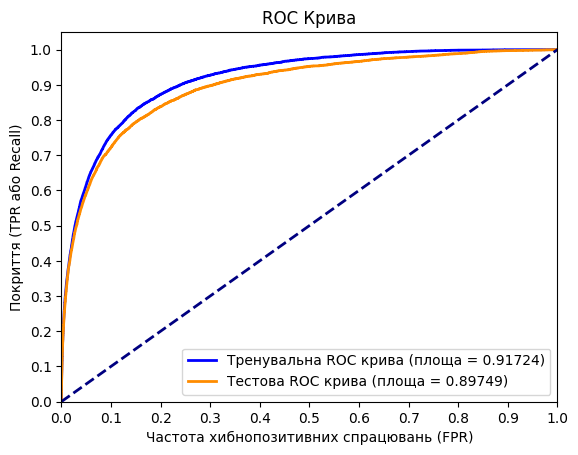

In [19]:
# Побудова ROC-кривої
plt.figure()

# Тренувальний набір
plt.plot(fpr_train_2, tpr_train_2, color='blue', lw=2, label=f'Тренувальна ROC крива (площа = {train_fe_auc_2:.5f})')

# Тестовий набір
plt.plot(fpr_test_2, tpr_test_2, color='darkorange', lw=2, label=f'Тестова ROC крива (площа = {test_auc_2:.5f})')


# Діагональ
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.00, 1.00])
plt.ylim([0.0, 1.05])
plt.xlabel('Частота хибнопозитивних спрацювань (FPR)')
plt.ylabel('Покриття (TPR або Recall)')
plt.title('ROC Крива')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc="lower right")
plt.show()


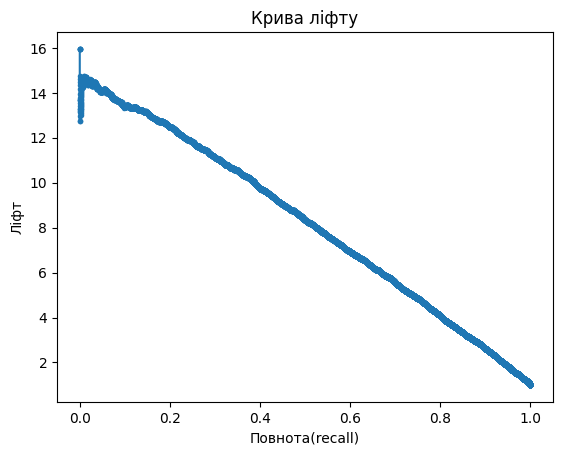

In [27]:
precision_2, recall_2, thresholds_2 = precision_recall_curve(Y_test, y_pred_proba_2[:, 1])

# Visualization of Lift Curve
lift_2 = precision_2 / (np.sum(Y_test) / len(Y_test))
plt.plot(recall_2, lift_2, marker='.')
plt.xlabel('Повнота(recall)')
plt.ylabel('Ліфт')
plt.title('Крива ліфту')
plt.show()

In [ ]:
# Make Histogram of Predictions
plt.figure(figsize=(12, 6))
plt.hist(y_pred_proba_2[:, 1][Y_test == 0], bins=100, alpha=0.5, label='Не відтік')
plt.hist(y_pred_proba_2[:, 1][Y_test == 1], bins=100, alpha=0.5, label='Відтік')
plt.xlabel('Ймовірність прогнозів', fontsize=12)
plt.ylabel('Кількість', fontsize=12)
plt.legend(fontsize=12)
plt.title('Гістограма прогнозування', fontsize=16)
plt.xticks(np.arange(0, 1.05, 0.05), fontsize=12)
plt.yticks(np.arange(0, 7500, 500),fontsize=12)
plt.show()

In [ ]:
y_pred_proba_churn = best_model_xgb_2.predict_proba(test_fe)[:, 1]
results = []

for threshold in np.arange(0.00, 1.01, 0.05):
    predicted = (y_pred_proba_churn >= threshold).astype(int)
    
    TP = np.sum((predicted == 1) & (Y_test == 1))
    FP = np.sum((predicted == 1) & (Y_test == 0))
    
    # Handle division by zero for precision
    if TP + FP == 0:
        precision = 0
    else:
        precision = TP / (TP + FP)
    precision = round(precision, 3)
    
    # Handle division by zero for recall
    if np.sum(Y_test == 1) == 0:
        recall = 0
    else:
        recall = TP / np.sum(Y_test == 1)
    recall = round(recall, 3)
    
    # Handle division by zero for lift
    mean_y_test = np.mean(Y_test)
    if mean_y_test == 0 or TP + FP == 0:
        lift = 0
    else:
        lift = (TP / (TP + FP)) / mean_y_test
    lift = round(lift, 1)
    
    # Calculate F score (beta=2)
    if precision + recall == 0:
        f1 = 0
        f2_score = 0 
    else:
        f1 = f1_score(Y_test, predicted).astype(float)
        f2_score = fbeta_score(Y_test, predicted, beta=2).astype(float)
#         f2 = 5 * ((precision * recall) / (4* precision + recall))
    f1 = round(f1, 3)
    f2_score = round(f2_score, 3)
    results.append({
        'Межа відбору': round(threshold,2),
        'Доля вибірки, %': round((TP + FP)/ len(Y_test) * 100,1),
        'Відтік': TP,
        'Хибно прогнозований відтік': FP,
        'Ліфт': lift,
        'Покриття (Recall)': recall,
        'Точність(Precision)': precision,
        'Збалансований індекс точності та покриття (F1)': f1,
        'F-міра з β=2': f2_score
    })

# Створення DataFrame з результатами
results_df = pd.DataFrame(results)

# Вивід результатів
results_df.sort_values('Доля вибірки, %')

In [ ]:
results_df.sort_values('Доля вибірки, %').to_excel('Таблиця_вибору_межі_відбору_xgb_70f_auc_89_749.xlsx')

## Marketing_activity

In [ ]:
# Задана межа для прогнозування відтоку
threshold = 0.65

# Перетворення ймовірностей на бінарні прогнози
predicted_for_marketing = (y_pred_proba_churn >= threshold).astype(int)

In [ ]:
tp_df = pd.DataFrame((predicted_for_marketing == 1) & (Y_test == 1))
tp_df = tp_df['target'].astype(int).to_frame()
tp_df = tp_df.rename(columns={'target': 'TP'})
tp_df

In [ ]:
fp_df = pd.DataFrame((predicted_for_marketing == 1) & (Y_test == 0))
fp_df = fp_df['target'].astype(int).to_frame()
fp_df = fp_df.rename(columns={'target': 'FP'})
fp_df

In [ ]:
merge_marketig_df = pd.concat([Y_test, tp_df, fp_df, test_fe['num_act_days_min_mnt3'].to_frame(), test_fe['days_of_last_ppm'].to_frame()], axis=1)
merge_marketig_df.describe()

In [ ]:
merge_marketig_df[(merge_marketig_df['days_of_last_ppm']>0) & (merge_marketig_df['days_of_last_ppm']<=25)].sum()

## 6.1 Features importance

In [16]:
f_i_2 = features_importance(train_fe, best_model_xgb_2)
f_i_2

,importances,cumulative_importance
columns,,
num_act_days_min_mnt3,0.295916,0.295916
num_act_days_min_mnt1,0.139427,0.435342
num_act_days_mea_mnt1,0.056798,0.492140
device_brand_xiaomi,0.047319,0.539460
voice_in_td_cnt_min_mnt1,0.046971,0.586431
...,...,...
voice_mts_out_drest_partmea_mnt3,0.003186,0.988256
non_accum_internet_vol_max_mnt3,0.003185,0.991441
voice_out_td_cnt_td_mnt3,0.003168,0.994609


In [ ]:
f_i.to_excel('feature_importance_xgb_89_700_20072024.xlsx')

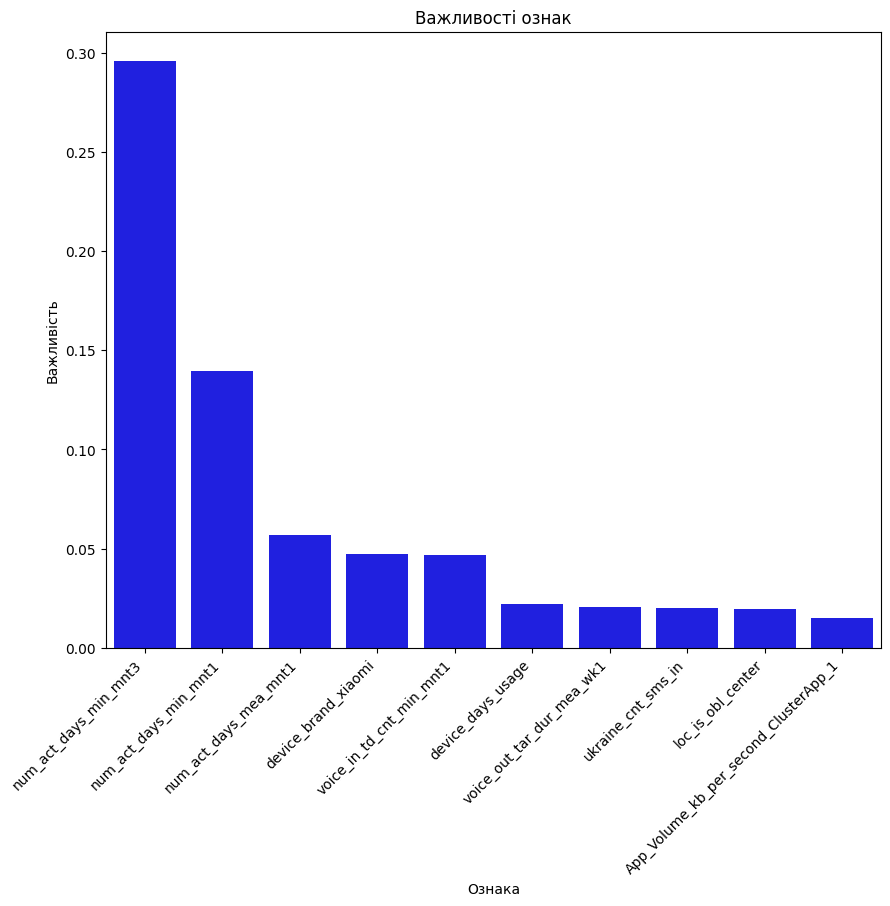

In [21]:
features_to_show = f_i_2[:10].index
features_to_show_df = f_i_2.loc[features_to_show,:]

plt.figure(figsize=(10, 8))
sns.barplot(x=features_to_show, y='importances', data=features_to_show_df, color='blue')
plt.title('Важливості ознак')
plt.xlabel('Ознака')
plt.ylabel('Важливість')
plt.xticks(range(len(features_to_show)), [str(p) for p in features_to_show], rotation=45, ha='right')
plt.show()

## 6.2 SHAP analyse

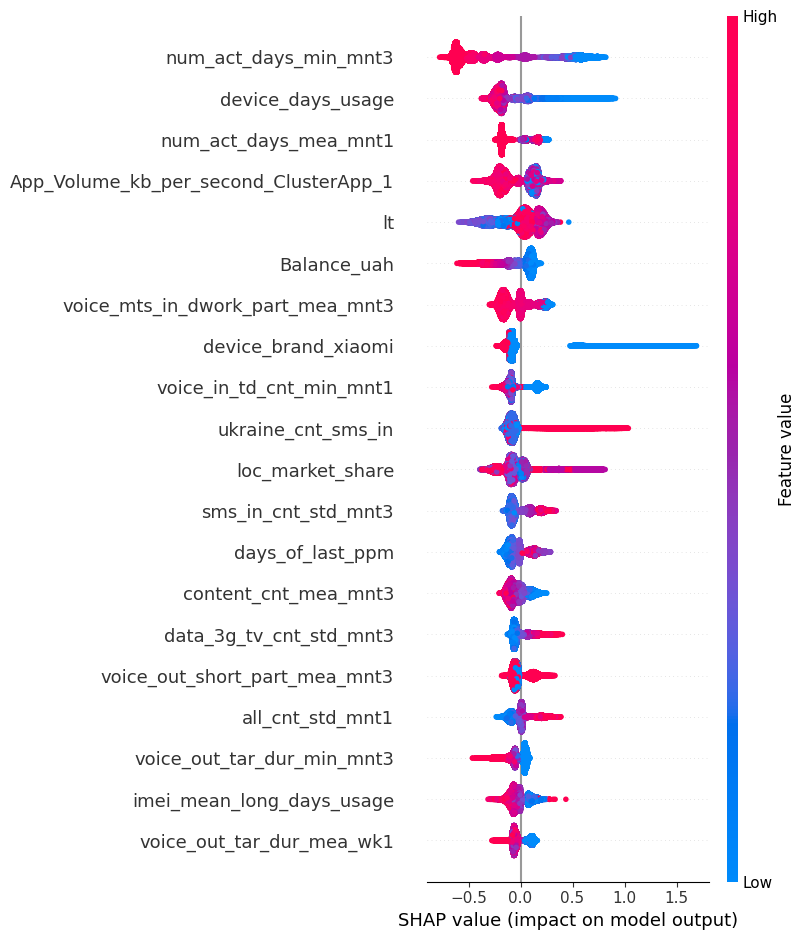

In [17]:
# Evaluate SHAP values
explainer_xgb_2 = shap.TreeExplainer(best_model_xgb_2)
shap_values_xgb_2 = explainer_xgb_2.shap_values(train_fe)

# Plot SHAP values importance
shap.summary_plot(shap_values_xgb_2, train_fe)

In [1]:
explainer_2 = shap.Explainer(best_model_xgb_2)
shap_values_2 = explainer_2(train_fe)

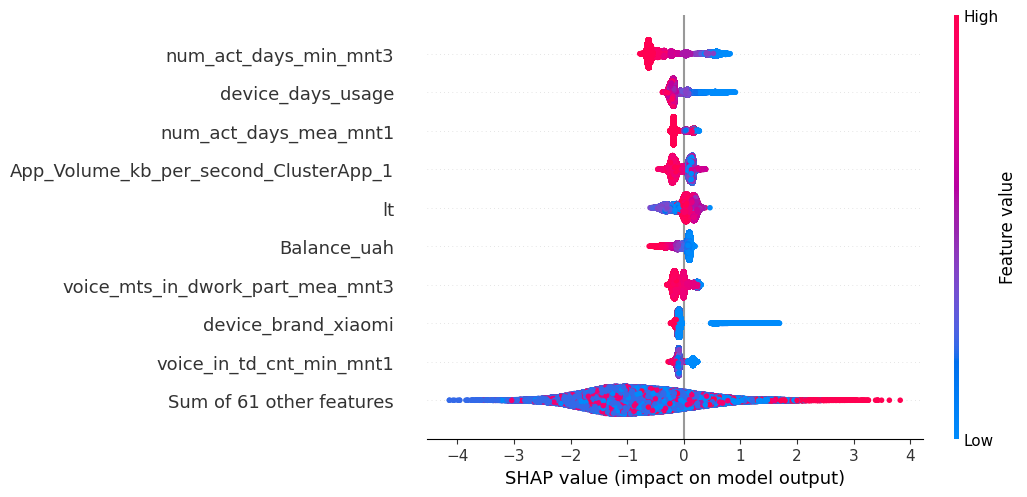

In [33]:
shap.plots.beeswarm(shap_values_2)

In [9]:
x = pd.concat(top_10_features_df, Y_train)
x

NameError: name 'top_10_features_df' is not defined

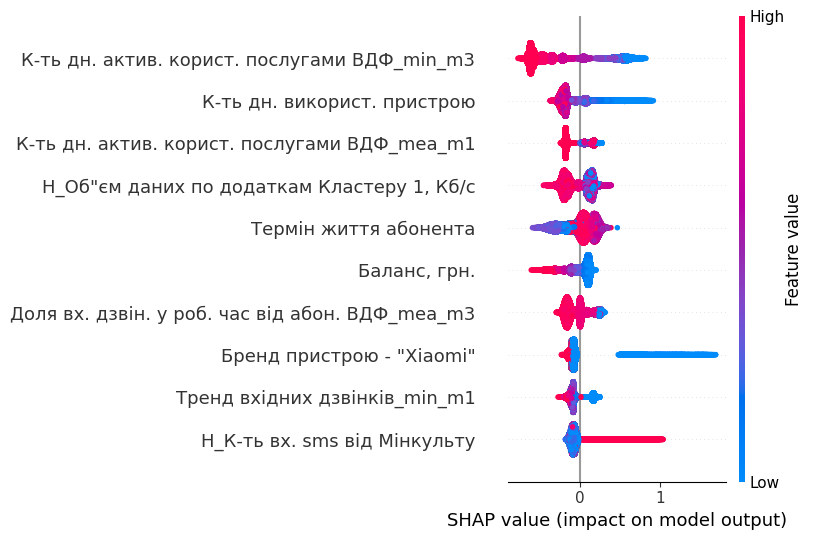

In [34]:
# Будуємо графік з перекладеними назвами ознак для вибраного числа ознак

# Створення DataFrame для значень SHAP і обчислення середніх значень
shap_values_df = pd.DataFrame(shap_values_xgb_2, columns=train_fe.columns)
shap_mean_values = shap_values_df.abs().mean().sort_values(ascending=False)

# Вибір 10 головних ознак
top_10_features = shap_mean_values.index[:10]
shap_values_top_10 = shap_values_df[top_10_features].values

# Перейменовуємо ознаки на українську
columns_rename = {'num_act_days_min_mnt3': 'К-ть дн. актив. корист. послугами ВДФ_min_m3',
'device_days_usage': 'К-ть дн. використ. пристрою',
'num_act_days_mea_mnt1': 'К-ть дн. актив. корист. послугами ВДФ_mea_m1',
'App_Volume_kb_per_second_ClusterApp_1': 'Н_Об"єм даних по додаткам Кластеру 1, Кб/с',
'lt': 'Термін життя абонента',
'Balance_uah': 'Баланс, грн.',
'voice_mts_in_dwork_part_mea_mnt3': 'Доля вх. дзвін. у роб. час від абон. ВДФ_mea_m3',
'device_brand_xiaomi': 'Бренд пристрою - "Xiaomi"',
'voice_in_td_cnt_min_mnt1': 'Тренд вхідних дзвінків_min_m1',
'ukraine_cnt_sms_in': 'Н_К-ть вх. sms від Мінкульту'
}
top_10_features_df = train_fe[top_10_features].rename(columns=columns_rename)

# Відображення графіка beeswarm для 10 головних ознак
# shap_values_2 = shap_values_top_10
shap.summary_plot(shap_values_top_10, top_10_features_df)

In [ ]:
corr_matrix = train_fe[top_10_features].corr()

# Створення теплової карти (heatmap) кореляцій
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Кореляційна матриця для top_10_features')
plt.tight_layout()
plt.show()

# # Виведення кореляцій для 'App_Volume_kb_per_second_ClusterApp_1'
# print("\nКореляції для 'App_Volume_kb_per_second_ClusterApp_1':")
# print(corr_matrix['App_Volume_kb_per_second_ClusterApp_1'].sort_values(ascending=False))

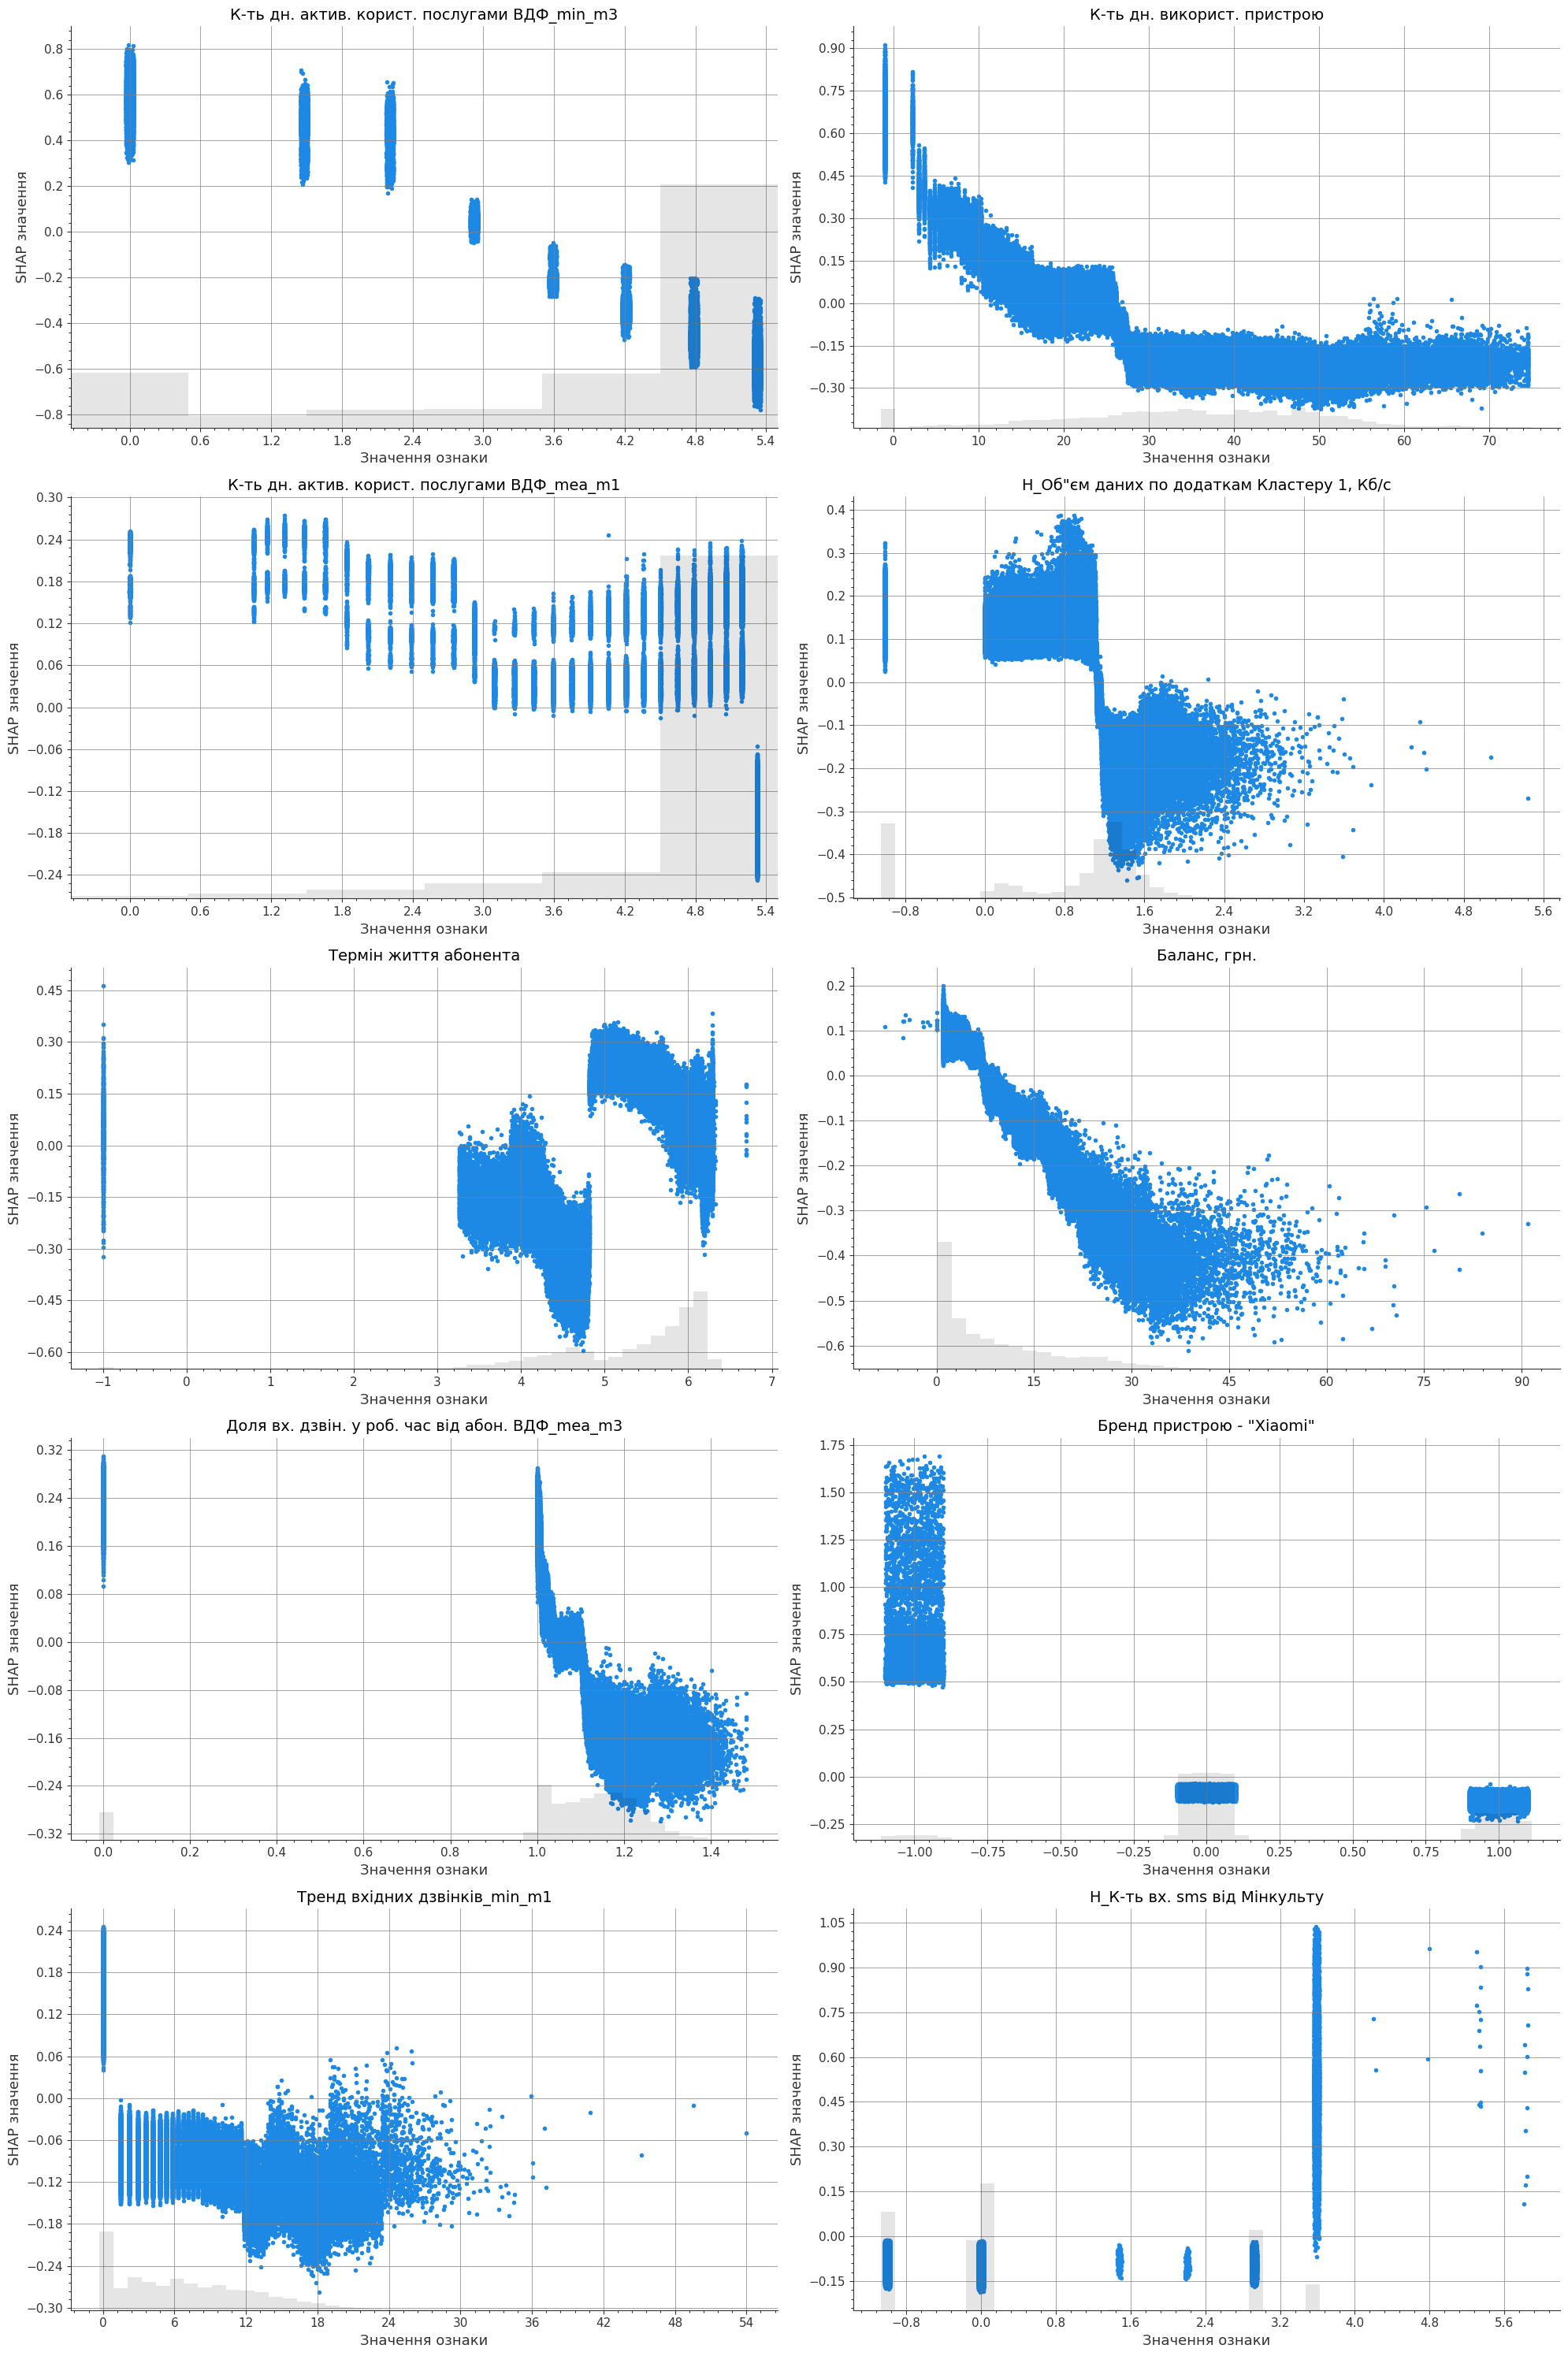

In [35]:
# Створюємо фігуру з 5 рядками та 2 стовпцями
fig, axs = plt.subplots(5, 2, figsize=(20, 30))
axs = axs.flatten()  # Перетворюємо 2D масив осей в 1D для зручності

for i, feature in enumerate(shap_mean_values_xgb_2.index[:10]):
    # Створюємо SHAP scatter plot для поточної ознаки
    shap.plots.scatter(shap_values_2[:, feature], ax=axs[i], show=False)
    
    # Налаштовуємо осі
    axs[i].set_title(top_10_features_df.columns[i], fontsize=14) # Використовуємо перекладені назви ознак
    axs[i].tick_params(axis='both', which='major', labelsize=11)
    axs[i].tick_params(axis='both', which='minor', labelsize=11)
    
    # Збільшуємо кількість поділок на осях
    axs[i].xaxis.set_major_locator(ticker.MaxNLocator(10))
    axs[i].yaxis.set_major_locator(ticker.MaxNLocator(10))
    
    # Додаємо мінорні поділки
    axs[i].xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    axs[i].yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    
    # Додаємо сітку
    axs[i].grid(which='major', linestyle='-', linewidth='0.5', color='gray')
#     axs[i].grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    
    plt.xlabel('Значення ознаки', fontsize = 13)
    plt.ylabel('SHAP значення', fontsize = 13)

# Налаштовуємо відступи між підграфіками
plt.tight_layout()

# Показуємо графік
plt.show()

In [ ]:
# Mean SHAP values
shap.plots.bar(shap_values_2)

In [2]:
# Receive shap values
shap_mean_values_xgb_2 = sorted_SHAP_values(shap_values_xgb_2,train_fe)
shap_mean_values_xgb_2

,importances,cumulative_importance
num_act_days_min_mnt3,0.501491,0.501491
device_days_usage,0.200959,0.702450
num_act_days_mea_mnt1,0.158463,0.860913
App_Volume_kb_per_second_ClusterApp_1,0.157048,1.017961
lt,0.147962,1.165923
...,...,...
MV_Traf_innet_inc_v_Min,0.015015,4.289413
voice_in_td_cnt_mea_wk1,0.013145,4.302559
sms_in_cnt_mea_mnt1,0.011937,4.314496
sms_in_cnt_mea_mnt3,0.008568,4.323064


In [7]:
# Number of features left in final data set 8 generated features
len(set(shap_mean_values_xgb_2.index) & set(added_features))

8

In [8]:
set(shap_mean_values_xgb_2.index) & set(added_features)

{'App_Duration_sec_per_Day_ClusterApp_1',
 'App_Events_per_Day_ClusterApp_1',
 'App_Volume_kb_per_second_ClusterApp_1',
 'App_Volume_kb_per_second_ClusterApp_4',
 'N_amc_3_to_1_voice_in_td_cnt_mea',
 'SUM_of_Duration_sec_ClusterApp_1',
 'cyberpol_cnt_sms_in',
 'ukraine_cnt_sms_in'}

In [ ]:
for i in shap_mean_values_xgb_2.index[:10]:
    shap.plots.scatter(shap_values_2[:,i])


In [ ]:
# Add descriptions to main features
features_xgb_w_descr_2 = pd.merge(
    shap_mean_values_xgb_2,
    train_fe_desc[['Feature Description (For participants)']],
    left_index=True,
    right_index=True,
    how='left'
)
features_xgb_w_descr_2

In [ ]:
# Save features with descriptions
features_xgb_w_descr_2.to_excel('features_xgb_70f_89_749_auc_20072024_with_description.xlsx')

In [ ]:
train_fe['App_Volume_kb_per_second_ClusterApp_1'][(train_fe['target']==0) & (train_fe['App_Volume_kb_per_second_ClusterApp_1']>0)].describe()

## Step 7: Save model and features

In [ ]:
# Save the best_model and features to files
# Save model
with open('model_XGB_70f_rfecv_diff_1_97_20072024_auc_89749.pkl', 'wb') as handle:
    pickle.dump(best_model_xgb_2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Save features
pd.concat([pd.DataFrame(features_names_xgb_2).set_index(0),shap_mean_values_xgb_2], axis = 1).to_excel('features_XGB_70f_rfecv_diff_1_97_20072024_auc_89749.xlsx')

# Additional models

## FS and LGBMClassifier model: РОЗРАХУНОК у файлі "LGBM_with_app_clusters_churn_model"

In [ ]:
model_lgbm = LGBMClassifier(objective = 'binary', metric = 'auc', n_jobs= -1, random_state = seed, verbose = 0)

#### Step 1: Features selection


In [ ]:
# Load train and test data
train_fe = pd.read_parquet('/kaggle/input/bdl5-final-project/train_fe_after_EDA_591_cyber_amg_apps_clustered_mis-1.parquet')
test_fe = pd.read_parquet('/kaggle/input/bdl5-final-project/test_fe_after_EDA_591_cyber_amg_apps_clustered_mis-1.parquet')

# Remove from main datasets 'target' column

Y_train = train_fe.target
train_fe.drop(columns='target', inplace = True)

Y_test = test_fe.target
test_fe.drop(columns='target', inplace = True)

x_train, x_valid, y_train, y_valid = train_test_split(train_fe, Y_train, train_size=0.7, random_state=seed)

train_fe.shape

#### Step 1.1: RFECV

In [ ]:
# Recursive feature elimination with cross-validation
rfecv_lgbm = RFECV(estimator = model_lgbm, 
                    step=20, 
                    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=seed),
                    scoring='roc_auc', 
                    min_features_to_select=80, 
                    verbose = 1)

start_time = time.time()
formatted_time = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
print(f'Stats at: {formatted_time}')

rfecv_lgbm.fit(train_fe, Y_train)

end_time =time.time()
print(f'Execution time: {end_time-start_time} seconds')

# Find numbers of important features
optimal_features_count_lgbm = rfecv_lgbm.n_features_
optimal_features_count_lgbm

In [ ]:
# Receiving names of selected features by RFECV

features_names_lgbm = train_fe.columns[rfecv_lgbm.support_].tolist()

print(f"Number of choosen features: {len(features_names_lgbm)}")

In [ ]:
cv_results_lgbm = pd.DataFrame(rfecv_lgbm.cv_results_)
cv_results_lgbm

#### Step 1.2: SHAP selection

In [ ]:
train_fe = train_fe[features_names_lgbm]
test_fe = test_fe[features_names_lgbm]
x_train, x_valid, y_train, y_valid = train_test_split(train_fe, Y_train, train_size=0.7, random_state=seed)
train_fe.shape

In [ ]:
model_lgbm.fit(train_fe, Y_train)

In [ ]:
# Evaluate SHAP values
explainer_lgbm_1 = shap.TreeExplainer(model_lgbm)
shap_values_lgbm_1 = explainer_lgbm_1.shap_values(train_fe)

if isinstance(shap_values_lgbm_1, list):
    shap_values_lgbm_1 = shap_values_lgbm_1[1] 

# Show features importance
shap.summary_plot(shap_values_lgbm_1, train_fe)

In [ ]:
# Recieve df of sorted SHAP values
shap_sorted_values_lgbm_1 = sorted_SHAP_values(shap_values_lgbm_1, train_fe)
shap_sorted_values_lgbm_1

In [ ]:
# Get SHAP features with cumulative values 80%
features_shap_lgbm_1 = shap_sorted_values_lgbm_1[shap_sorted_values_lgbm_1['cumulative_importance'] <= shap_sorted_values_lgbm_1.iloc[-1,1]*0.8]
features_shap_lgbm_1

#### Step 1.3: Feature importance selection

In [ ]:
# Get features with cumulative feature_importance values 80%
features_lgbm_f_i = features_importance(train_fe, model_lgbm)
features_lgbm_f_i = features_lgbm_f_i[features_lgbm_f_i['cumulative_importance'] <= features_lgbm_f_i.iloc[-1,1]*0.8]
features_lgbm_f_i

#### Step 1.4: Intersected selection - SHAP and features_importance

In [ ]:
# Get intersected features: SHAP vs features_importance
features_shap_f_i_lgbm = list(set(features_shap_lgbm_1.index) & set(features_lgbm_f_i.index))
len(features_shap_f_i_lgbm)

#### Step 2: GridSearchCV

In [ ]:
# Load train and test data
train_fe = pd.read_parquet('/kaggle/input/bdl5-final-project/train_fe_after_EDA_591_cyber_amg_apps_clustered_mis-1.parquet')
test_fe = pd.read_parquet('/kaggle/input/bdl5-final-project/test_fe_after_EDA_591_cyber_amg_apps_clustered_mis-1.parquet')

# Remove from main datasets 'target' column

Y_train = train_fe.target
train_fe.drop(columns='target', inplace = True)

Y_test = test_fe.target
test_fe.drop(columns='target', inplace = True)

x_train, x_valid, y_train, y_valid = train_test_split(train_fe, Y_train, train_size=0.7, random_state=seed)

train_fe.shape

In [ ]:
train_fe = train_fe[features_shap_f_i_lgbm]
test_fe = test_fe[features_shap_f_i_lgbm]
x_train, x_valid, y_train, y_valid = train_test_split(train_fe, Y_train, train_size=0.7, random_state=seed)
train_fe.shape

In [ ]:
# Find the best LGBM model parameters using GridSearchCV
start_time = time.time()
formatted_time = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
print(f'Stats at: {formatted_time}')

param_grid_shap_f_i_lgbm = {'objective':['binary'],
                            'force_col_wise': [True],
#                             'force_row_wise': [True], # this parameter cannot be used at the same time with force_col_wise, choose only one of them
                            # 'is_unbalance' : [True],
                            'scale_pos_weight': [14.6478],# this parameter cannot be used at the same time with is_unbalance, choose only one of them
                            'tree_learner': ['voting_parallel'],
                            'learning_rate': [0.03], #Ok [0.03]
                            'max_depth': [5], # limit the max depth for tree model. This is used to deal with over-fitting when #data is small
#                             'min_data_in_leaf': [30, 40],
                            'num_leaves': [32], # np.arange(32,49,16),
                            'verbose': [0],
                            'n_estimators': [200], #np.arange(100,400,100)
                            'reg_alpha': [0.05],
                            'reg_lambda': [0.8], #Ok [0.8]
                             'metrics': ['auc'],
                             'early_stopping_round': [10] #Ok 10
             }

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
# stratified_kfold_repeated = RepeatedStratifiedKFold(n_splits=3, n_repeats = 10, random_state=seed)

grid_search_shap_f_i_lgbm = GridSearchCV(
    model_lgbm, 
    param_grid_shap_f_i_lgbm, 
    scoring='roc_auc',
    #     scoring=auc_difference, 
    return_train_score=True,             
    n_jobs = -1, 
    cv = stratified_kfold, 
    verbose = 3,
#     refit='ROC_AUC' # For multi-metric scoring, the parameter refit must be set to a scorer key
    refit=True  # Ensure the final model is refit on the entire training set
)

fit_params = {
    'eval_set': [(x_valid, y_valid)]
  #  'eval_metric': 'auc' 
  #  'early_stopping_round': 15
}

grid_search_shap_f_i_lgbm.fit(train_fe, Y_train, **fit_params)
# grid_search_shap_f_i_lgbm.fit(x_train, y_train, **fit_params)

end_time =time.time()
print(f'Execution time: {end_time-start_time} seconds')

In [ ]:
cv_results_grid_search_shap_f_i_lgbm = pd.DataFrame(grid_search_shap_f_i_lgbm.cv_results_)
# cv_results_grid_search_shap_f_i_lgbm.to_excel('cv_results_grid_search_shap_f_i_lgbm_2_dep150-200.xlsx')
cv_results_grid_search_shap_f_i_lgbm['mix_params'] = (
#     'L2: '+
#     cv_results_grid_search_shap_f_i_lgbm['param_reg_lambda'].astype(str)+
#     'L1: '+
#     cv_results_grid_search_shap_f_i_lgbm['param_reg_alpha'].astype(str) +
   'max_depth: ' +
    cv_results_grid_search_shap_f_i_lgbm['param_max_depth'].astype(str)+
'; #_estim: '+
    cv_results_grid_search_shap_f_i_lgbm['param_n_estimators'].astype(str)
# 'min_data_in_leaf: '  +
#     cv_results_grid_search_shap_f_i_lgbm['param_min_data_in_leaf'].astype(str)
)

In [ ]:
train_scores = cv_results_grid_search_shap_f_i_lgbm['mean_train_score'] 
test_scores = cv_results_grid_search_shap_f_i_lgbm['mean_test_score']
params = cv_results_grid_search_shap_f_i_lgbm['mix_params']

plt.figure(figsize=(12, 6))
plt.plot(train_scores, '-o', label='train')
plt.plot(test_scores, '-o', label='test')

for i, (train_score, test_score) in enumerate(zip(train_scores, test_scores)):
    plt.annotate(f'{train_score:.4f}', (i, train_score), textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate(f'{test_score:.5f}', (i, test_score), textcoords="offset points", xytext=(0,-15), ha='center')
    
    # Vertical lines
    plt.plot([i, i], [train_score, test_score], 'k--')
    
    # differences
    diff = train_score - test_score
    plt.annotate(f'{diff:.4f}', (i, (train_score + test_score) / 2), textcoords="offset points", xytext=(5,0), ha='left', color='red')

plt.xlabel('Параметри')
plt.ylabel('Середнє ROC_AUC')
plt.title('Результати тренувального і тестового набору')
plt.legend(loc='best')

plt.xticks(range(len(params)), [str(p) for p in params], rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
train_scores = cv_results_grid_search_shap_f_i_lgbm['mean_train_score'] 
test_scores = cv_results_grid_search_shap_f_i_lgbm['mean_test_score']
params = cv_results_grid_search_shap_f_i_lgbm['param_num_leaves']

plt.figure(figsize=(12, 6))
plt.plot(train_scores, '-o', label='train')
plt.plot(test_scores, '-o', label='test')

for i, (train_score, test_score) in enumerate(zip(train_scores, test_scores)):
    plt.annotate(f'{train_score:.3f}', (i, train_score), textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate(f'{test_score:.4f}', (i, test_score), textcoords="offset points", xytext=(0,-15), ha='center')

plt.xlabel('Параметри')
plt.ylabel('Середнє ROC_AUC')
plt.title('Результати тренувального і тестового набору')
plt.legend(loc='best')

plt.xticks(range(len(params)), [str(p) for p in params], rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Step 3: Evaluate results

In [ ]:
# Best parameters
print("Best parameters:", grid_search_shap_f_i_lgbm.best_params_)

# Best score
print("Best score (AUC):", (grid_search_shap_f_i_lgbm.best_score_))

best_model_shap_f_i_lgbm = grid_search_shap_f_i_lgbm.best_estimator_

# # All parameters of best model
# print("All parameters: ", (grid_search_shap_f_i_lgbm.get_params()))

In [ ]:
y_pred_proba_shap_f_i_lgbm = best_model_shap_f_i_lgbm.predict_proba(test_fe)[:, 1]
auc_score_shap_f_i_lgbm = roc_auc_score(Y_test, y_pred_proba_shap_f_i_lgbm)
print(f'test AUC_score  = {round(auc_score_shap_f_i_lgbm,5)}')

In [ ]:
# Scores validation

train_fe_auc_lgbm = roc_auc_score(Y_train, best_model_shap_f_i_lgbm.predict_proba(train_fe)[:, 1])
test_auc_lgbm = roc_auc_score(Y_test, best_model_shap_f_i_lgbm.predict_proba(test_fe)[:, 1])
diff_AUC = (train_fe_auc_lgbm - test_auc_lgbm)*100

print(f" train_fe_AUC: {train_fe_auc_lgbm:.5f}")
print(f" test_AUC: {test_auc_lgbm:.5f}")
print(f" Diff_AUC train - test: {diff_AUC:.5f} %")

In [ ]:
y_pred_proba_shap_f_i_lgbm_1 = best_model_shap_f_i_lgbm.predict_proba(test_fe)
y_pred_shap_f_i_lgbm = (y_pred_proba_shap_f_i_lgbm_1[:, 1] >= 0.5).astype(int)
cnf_matrix_shap_f_i_lgbm = confusion_matrix(Y_test, y_pred_shap_f_i_lgbm)
print('Confusion matrix')
print(cnf_matrix_shap_f_i_lgbm)
print('---------------')
print(classification_report(Y_test, y_pred_shap_f_i_lgbm))

In [ ]:
# Calculate ROC-curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba_shap_f_i_lgbm)

# # Calculate AUC
# roc_auc = roc_auc_score(y_test, y_scores)

# Draw a plot of ROC-curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score_shap_f_i_lgbm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
precision, recall, thresholds = precision_recall_curve(Y_test, y_pred_proba_shap_f_i_lgbm)
average_precision = average_precision_score(Y_test, y_pred_proba_shap_f_i_lgbm)
average_precision

In [ ]:
# Draw a plot of precision-recall curve
plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()

In [ ]:
# Evaluate SHAP values
explainer_shap_f_i_lgbm = shap.TreeExplainer(best_model_shap_f_i_lgbm)
shap_values_cross_lgbm = explainer_shap_f_i_lgbm.shap_values(train_fe)

if isinstance(shap_values_cross_lgbm, list):
    shap_values_cross_lgbm = shap_values_cross_lgbm[1] 

# Show features importance
shap.summary_plot(shap_values_cross_lgbm, train_fe)


In [ ]:
# Recieve df of sorted SHAP values
shap_sorted_values_cross_lgbm = sorted_SHAP_values(shap_values_cross_lgbm, train_fe)
shap_sorted_values_cross_lgbm

#### Step 4: Save model and features

In [ ]:
# Save the best_model and features to files
# Save model
with open('model_LGBM_96f_rfecv_shap_f_i_diff_2_29_07072024_auc_89829.pkl', 'wb') as handle:
    pickle.dump(best_model_shap_f_i_lgbm, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Save features
pd.concat([pd.DataFrame(features_shap_f_i_lgbm).set_index(0),shap_sorted_values_cross_lgbm], axis = 1).to_excel('features_LGBM_96f_rfecv_shap_f_i_diff_2_29_07072024_auc_89829.xlsx')

# Ensemble prediction

### Load data and models

In [ ]:
train_fe = pd.read_parquet('/kaggle/input/bdl5-final-project/train_fe_after_EDA_591_cyber_amg_apps_clustered_mis-1.parquet')
test_fe = pd.read_parquet('/kaggle/input/bdl5-final-project/test_fe_after_EDA_591_cyber_amg_apps_clustered_mis-1.parquet')

# Remove from train dataset 'target' column
Y_train = train_fe.target
train_fe.drop(columns='target', inplace = True)

# Remove from test dataset 'target' column
Y_test = test_fe.target
test_fe.drop(columns='target', inplace = True)

train_fe.head()

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## XGB

In [ ]:
# Load the model from the file
with open('/kaggle/input/models-and-features/model_XGB_70f_rfecv_diff_1_97_20072024_auc_89749.pkl', 'rb') as handle:
    XGB_model = pickle.load(handle)
    
XGB_features = pd.read_excel('/kaggle/input/models-and-features/features_XGB_70f_rfecv_diff_1_97_20072024_auc_89749.xlsx')

In [ ]:
XGB_features = list(XGB_features['Unnamed: 0'])

In [ ]:
len(XGB_features)

In [ ]:
XGB_model

In [ ]:
train_fe_XGB = train_fe[XGB_features]
test_fe_XGB = test_fe[XGB_features]

In [ ]:
train_fe_XGB.shape

In [ ]:
# Scores validation
train_fe_auc_XGB = roc_auc_score(Y_train, XGB_model.predict_proba(train_fe_XGB)[:, 1])
test_auc_XGB = roc_auc_score(Y_test, XGB_model.predict_proba(test_fe_XGB)[:, 1])
diff_AUC_XGB = (train_fe_auc_XGB - test_auc_XGB)*100

print(f" train_fe_AUC: {train_fe_auc_XGB:.5f}")
print(f" test_AUC: {test_auc_XGB:.5f}")
print(f" Diff_AUC train - test: {diff_AUC_XGB:.5f} %")

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## LGBM

In [ ]:
# Load the model from the file
with open('/kaggle/input/models-and-features/model_LGBM_94f_rfecv_shap_diff_1_98_20072024_auc_89689.pkl', 'rb') as handle:
    LGBM_model = pickle.load(handle)
    
LGBM_features = pd.read_excel('/kaggle/input/models-and-features/features_LGBM_94f_rfecv_shap_diff_1_98_20072024_auc_89689.xlsx')

In [ ]:
LGBM_model

In [ ]:
LGBM_features = list(LGBM_features['Unnamed: 0'])

In [ ]:
len(LGBM_features)

In [ ]:
# train_fe_LGBM = train_fe[features_shap_f_i_lgbm]
# test_fe_LGBM = test_fe[features_shap_f_i_lgbm]

In [ ]:
train_fe_LGBM = train_fe[LGBM_features]
test_fe_LGBM = test_fe[LGBM_features]

In [ ]:
# Scores validation
train_fe_auc_LGBM = roc_auc_score(Y_train, LGBM_model.predict_proba(train_fe_LGBM)[:, 1])
test_auc_LGBM = roc_auc_score(Y_test, LGBM_model.predict_proba(test_fe_LGBM)[:, 1])
diff_AUC_LGBM = (train_fe_auc_LGBM - test_auc_LGBM)*100

print(f" train_fe_AUC: {train_fe_auc_LGBM:.5f}")
print(f" test_AUC: {test_auc_LGBM:.5f}")
print(f" Diff_AUC train - test: {diff_AUC_LGBM:.5f} %")

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## XGB_2

In [ ]:
# Load the model from the file
with open('/kaggle/input/models-and-features/model_XGB_44f_shap_after_110f_diff_1_85_20072024_auc_89681.pkl', 'rb') as handle:
    XGB_model_2 = pickle.load(handle)
    
XGB_features_2 = pd.read_excel('/kaggle/input/models-and-features/features_XGB_44f_shap_after_110f_diff_1_85_20072024_auc_89681.xlsx')

In [ ]:
XGB_features_2 = list(XGB_features_2['Unnamed: 0'])

In [ ]:
len(XGB_features_2)

In [ ]:
XGB_model_2

In [ ]:
train_fe_XGB_2 = train_fe[XGB_features_2]
test_fe_XGB_2 = test_fe[XGB_features_2]

In [ ]:
train_fe_XGB_2.shape

In [ ]:
# Scores validation
train_fe_auc_XGB_2 = roc_auc_score(Y_train, XGB_model_2.predict_proba(train_fe_XGB_2)[:, 1])
test_auc_XGB_2 = roc_auc_score(Y_test, XGB_model_2.predict_proba(test_fe_XGB_2)[:, 1])
diff_AUC_XGB_2 = (train_fe_auc_XGB_2 - test_auc_XGB_2)*100

print(f" train_fe_AUC: {train_fe_auc_XGB_2:.5f}")
print(f" test_AUC: {test_auc_XGB_2:.5f}")
print(f" Diff_AUC train - test: {diff_AUC_XGB_2:.5f} %")

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
xgb_clf = XGB_model.set_params(eval_set=None, eval_metric=None, early_stopping_rounds = None)
xgb_clf_2 = XGB_model_2.set_params(eval_set=None, eval_metric=None, early_stopping_rounds = None)
lgbm_clf = LGBM_model.set_params(eval_set=None, early_stopping_round = None)
# lgbm_clf = best_model_shap_f_i_lgbm.set_params(eval_set=None, early_stopping_round = None)
# lgbm_clf = LGBM_model


In [ ]:
features_metamod = list((set(set(XGB_features) | set(LGBM_features))))
len(features_metamod)

In [ ]:
features_metamod_3 = list((set(set(XGB_features) | set(LGBM_features) | set(XGB_features_2))))
len(features_metamod_3)

## Models timing

In [ ]:
model_timing(XGB_model,train_fe_XGB, Y_train,test_fe_XGB,2)

In [ ]:
model_timing(LGBM_model,train_fe_LGBM, Y_train,test_fe_LGBM,50)

In [ ]:
model_timing(XGB_model_2,train_fe_XGB_2, Y_train,test_fe_XGB_2,50)

## #1 Joining results

In [ ]:
y_pred_proba_XGB = XGB_model.predict_proba(test_fe_XGB)[:, 1]
y_pred_proba_LGBM = LGBM_model.predict_proba(test_fe_LGBM)[:, 1]
ensemble_pred_fin = None
auc_score_ensemble = 0
coeff = []
for w1 in np.linspace(0, 1, 20):
    ensemble_pred = y_pred_proba_XGB * w1 + y_pred_proba_LGBM*(1-w1)
    auc_score_ensemble_train = roc_auc_score(Y_test, ensemble_pred)
    if auc_score_ensemble_train > auc_score_ensemble:
        auc_score_ensemble = auc_score_ensemble_train
        coeff = [w1, 1 - w1]
        ensemble_pred_fin = ensemble_pred
print(f'test_AUC_score  = {round(auc_score_ensemble,5)}')
print('Best coefficients: ', coeff)

## #2 Metamodel

In [ ]:
# Make StackingClassifier
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html

stacking_clf = StackingClassifier(
    estimators=[('xgb', xgb_clf), ('lgbm', lgbm_clf)],
    final_estimator =  lgbm_clf,
#     final_estimator =  LGBMClassifier(random_state=seed),
    stack_method = 'predict_proba',
    passthrough = True,
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed),
    n_jobs = -1,
    verbose = 3
)

stratified_kfold_met = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Сітка гіперпараметрів
param_grid_met = {
#     'xgb__n_estimators': [50, 100],
#     'xgb__max_depth': [3, 5],
#     'lgbm__n_estimators': [50, 100],
#     'lgbm__num_leaves': [31, 50],
    'lgbm__verbose': [-1],
    'final_estimator__n_estimators': [450, 500],
    'final_estimator__max_depth': [3, 4]
}

# Налаштування GridSearchCV
grid_search_met = GridSearchCV(
    stacking_clf,
    param_grid_met,
    scoring='roc_auc',
    return_train_score=True,             
    n_jobs = -1, 
    cv = stratified_kfold_met, 
    verbose = 3,
    refit=True
   )

# Train

start_time = time.time()
formatted_time = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
print(f'Stats at: {formatted_time}')

grid_search_met.fit(train_fe[features_metamod], Y_train)

end_time =time.time()
print(f'Execution time: {end_time-start_time} seconds')

best_params_met = grid_search_met.best_params_
print(f"Best parameters: {best_params_met}")


In [ ]:
best_model_met =  grid_search_met.best_estimator_
best_model_met = stacking_clf.set_params(**best_params_met)

# Lean best model
start_time = time.time()
formatted_time = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
print(f'Stats training at: {formatted_time}')

best_model_met.fit(train_fe[features_metamod], Y_train)

end_time =time.time()
print(f'Execution time: {end_time-start_time} seconds') 


In [ ]:
# Scores validation
train_fe_auc_met = roc_auc_score(Y_train, best_model_met.predict_proba(train_fe[features_metamod])[:, 1])

start_time = time.time()
formatted_time = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
print(f'Stats training at: {formatted_time}')

test_auc_met = roc_auc_score(Y_test, best_model_met.predict_proba(test_fe[features_metamod])[:, 1])

end_time =time.time()
print(f'Execution time: {end_time-start_time} seconds') 

diff_AUC_met = (train_fe_auc_met - test_auc_met)*100

print(f" train_fe_AUC: {train_fe_auc_met:.5f}")
print(f" test_AUC: {test_auc_met:.5f}")
print(f" Diff_AUC train - test: {diff_AUC_met:.5f} %")

In [ ]:
y_pred_proba_met = best_model_met.predict_proba(test_fe[features_metamod])[:, 1]
results_met = []
    
for threshold in np.arange(0.00, 1.01, 0.05):
    predicted = (y_pred_proba_met >= threshold).astype(int)
    
    TP = np.sum((predicted == 1) & (Y_test == 1))
    FP = np.sum((predicted == 1) & (Y_test == 0))
    precision = precision_score(Y_test, predicted).astype(float)
    precision = round(precision, 3)
    recall = recall_score(Y_test, predicted).astype(float)
    recall = round(recall, 3)
    lift = (TP / (TP + FP)) / (np.mean(Y_test)).astype(float)  # обчислення lift
    lift = round(lift, 1)
    f1 = f1_score(Y_test, predicted).astype(float)
    f1 = round(f1,3)
    
    results_met.append({
        'Межа': threshold,
        'Відтік': TP,
        'Хибно прогнозований відтік': FP,
        'Ліфт': lift,
        'Покриття (Recall)': recall,
        'Точність(Precision)': precision,
        'Збалансований індекс точності та покриття (F1)': f1
        
        
    })

# Створення DataFrame з результатами
results_df_met = pd.DataFrame(results)

# Вивід результатів
results_df_met


In [ ]:
results_df.to_excel('stacking_model_probabilities_thresholds.xlsx')

In [ ]:
# Find best threshold
fpr_met, tpr_met, thresholds_met = roc_curve(Y_test, stacking_clf.predict_proba(test_fe[features_metamod])[:, 1])

gmeans_met = np.sqrt(tpr_met * (1-fpr_met))
ix_met = np.argmax(gmeans_met)
best_threshold_met = thresholds_met[ix_met]
print(f'Optimal threshold: {best_threshold_met:.4f}')

best_fpr_met = fpr_met[ix_met]
best_tpr_met = tpr_met[ix_met]

In [ ]:
# Predict probabilies
y_pred_proba_2 = stacking_clf.predict_proba(test_fe[features_metamod])
y_pred_met = (y_pred_proba_2[:, 1] >= best_threshold_met).astype(int)
cnf_matrix_met = confusion_matrix(Y_test, y_pred_met)

# Draw Confusion Matrix fo 
plt.figure(figsize=(5, 3))
sns.heatmap(cnf_matrix_met, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Stacking Confusion Matrix')
plt.show()

print('---------------')
print('Stacking Classification report:\n ',classification_report(Y_test, y_pred_met))

In [ ]:
# Predict probabilies
y_pred_proba_1 = best_model_xgb.predict_proba(test_fe)
y_pred = (y_pred_proba_1[:, 1] >= best_threshold).astype(int)
cnf_matrix = confusion_matrix(Y_test, y_pred)

# Draw Confusion Matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

print('---------------')
print('Classification report:\n ',classification_report(Y_test, y_pred))

In [ ]:
# Make Histogram of Predictions
plt.hist(y_pred_proba_2[:, 1][Y_test == 0], bins=10, alpha=0.5, label='Not churn')
plt.hist(y_pred_proba_2[:, 1][Y_test == 1], bins=10, alpha=0.5, label='Churn')
plt.xlabel('Probabilities of predictions')
plt.ylabel('Quantity')
plt.legend()
plt.title('Histogram of Predictions (Stacking model)')
plt.show()

In [ ]:
# Draw precision-recall curve for Stacking
skplt.metrics.plot_precision_recall(Y_test, y_pred_proba_2)
plt.show()


In [ ]:
# Draw precision-recall curve XGB
skplt.metrics.plot_precision_recall(Y_test, y_pred_proba_1)
plt.show()


In [ ]:
# Save model and features to files
# Save model
with open('model_ensemb_131f_stacking_clf_20062024_auc_8999.pkl', 'wb') as handle:
    pickle.dump(stacking_clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save features
pd.DataFrame(features_metamod).to_excel('features_ensemb_131f_stacking_clf_20062024_auc_8999.xlsx')

In [ ]:
# Load the model from the file
with open('/kaggle/working/model_ensemb_131f_stacking_clf_20062024_auc_8999.pkl', 'rb') as handle:
    ensemb_load_model = pickle.load(handle)

In [ ]:
stacking_clf.score(test_fe[features_metamod], Y_test)

In [ ]:
roc_auc_score(Y_test, ensemb_load_model.predict_proba(test_fe[features_metamod])[:, 1])

In [ ]:
# Evaluate SHAP values

final_estimator = stacking_clf.final_estimator_

# Train the final estimator using the metafeatures
final_estimator.fit(stacking_clf.transform(train_fe[features_metamod]), Y_train)

# Evaluate SHAP values for the final estimator
explainer_final = shap.TreeExplainer(final_estimator)
shap_values_final = explainer_final.shap_values(stacking_clf.transform(test_fe[features_metamod]))

if isinstance(shap_values_final, list):
    shap_values_final = shap_values_final[0]

# Show feature importance
shap.summary_plot(shap_values_final, stacking_clf.transform(test_fe[features_metamod]))

## #3 VotingClassifier

In [ ]:
classifiers = [('xgb', xgb_clf), ('lgbm', lgbm_clf)]

param_grid_vot = {
    'weights': [(w1, 1 - w1) for w1 in np.linspace(0.4, 0.61, 4)]
}

voting_clf = VotingClassifier(estimators=classifiers, voting='soft', n_jobs=-1)

grid_search_voting = GridSearchCV(estimator=voting_clf, 
                                  param_grid=param_grid_vot, 
                                  scoring='roc_auc', 
                                  cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed),
                                  return_train_score=True,
                                  refit=True,
                                  verbose=3)

start_time = time.time()
formatted_time = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
print(f'Stats at: {formatted_time}')

grid_search_voting.fit(train_fe[features_metamod], Y_train)

end_time =time.time()
print(f'Execution time: {end_time-start_time} seconds')

print("Best parameters found: ", grid_search_voting.best_params_)
print("Best AUC-ROC score: ", grid_search_voting.best_score_)

best_model_vot = grid_search_voting.best_estimator_

In [ ]:
cv_results_grid_search_voting = pd.DataFrame(grid_search_voting.cv_results_)
cv_results_grid_search_voting

In [ ]:
# Scores validation
train_fe_auc_voting = roc_auc_score(Y_train, best_model_vot.predict_proba(train_fe[features_metamod])[:, 1])

start_time = time.time()
formatted_time = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
print(f'Stats training at: {formatted_time}')

test_auc_voting = roc_auc_score(Y_test, best_model_vot.predict_proba(test_fe[features_metamod])[:, 1])

end_time =time.time()
print(f'Execution time: {end_time-start_time} seconds')


diff_AUC_voting = (train_fe_auc_voting - test_auc_voting)*100

print(f" train_fe_AUC: {train_fe_auc_voting:.5f}")
print(f" test_AUC: {test_auc_voting:.5f}")
print(f" Diff_AUC train - test: {diff_AUC_voting:.5f} %")

In [ ]:
# Scores validation
train_fe_auc_voting = roc_auc_score(Y_train, best_model_vot.predict_proba(train_fe[features_metamod])[:, 1])
test_auc_voting = roc_auc_score(Y_test, best_model_vot.predict_proba(test_fe[features_metamod])[:, 1])
diff_AUC_voting = (train_fe_auc_voting - test_auc_voting)*100

print(f" train_fe_AUC: {train_fe_auc_voting:.5f}")
print(f" test_AUC: {test_auc_voting:.5f}")
print(f" Diff_AUC train - test: {diff_AUC_voting:.5f} %")

In [ ]:
# V1 for 3 classifiers
voting_clf = VotingClassifier(
    estimators=[('xgb', xgb_clf), ('lgbm', lgbm_clf)], #, ('xgb_2', xgb_clf_2)
    voting ='soft',
    weights = [0.61, 0.39], #[0.4, 0.3, 0.3]
    n_jobs = -1,
    verbose = 3
)

start_time = time.time()
formatted_time = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
print(f'Stats training at: {formatted_time}')

voting_clf.fit(train_fe[features_metamod], Y_train)

end_time =time.time()
print(f'Execution time: {end_time-start_time} seconds')

In [ ]:
# Scores validation
train_fe_auc_voting = roc_auc_score(Y_train, voting_clf.predict_proba(train_fe[features_metamod_3])[:, 1])

start_time = time.time()
formatted_time = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
print(f'Stats training at: {formatted_time}')

test_auc_voting = roc_auc_score(Y_test, voting_clf.predict_proba(test_fe[features_metamod_3])[:, 1])

end_time =time.time()
print(f'Execution time: {end_time-start_time} seconds')

diff_AUC_voting = (train_fe_auc_voting - test_auc_voting)*100

print(f" train_fe_AUC: {train_fe_auc_voting:.5f}")
print(f" test_AUC: {test_auc_voting:.5f}")
print(f" Diff_AUC train - test: {diff_AUC_voting:.5f} %")

In [ ]:
model_timing(voting_clf,train_fe[features_metamod], Y_train,test_fe[features_metamod_3],30)

## Skewness

In [ ]:
# # Find columns with skewness greater than a threshold
# skewness = train_fe.skew()

# threshold = 1

# highly_skewed_above_threshold = skewness[abs(skewness) > threshold]

# zero_skewed_columns = skewness[skewness == 0]

# highly_skewed_columns = pd.concat([highly_skewed_above_threshold, zero_skewed_columns])

# print(f"{len(highly_skewed_columns)} columns with highly skewed distribution:")
# print(highly_skewed_columns.sort_values())

In [ ]:
# qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
# for col in highly_skewed_columns.index:
#     if col != 'target':
#         train_fe[col] = qt.fit_transform(train_fe[[col]])
#         test_fe[col] =  qt.fit_transform(test_fe[[col]])

In [ ]:
# for col in highly_skewed_columns.index:
#     if col != 'target':
#         if highly_skewed_columns[col]<0:
#             train_fe[col] = train_fe[col].fillna(train_fe[col].mean())
#             test_fe[col] = test_fe[col].fillna(train_fe[col].mean())
            
#             train_fe[col], _ = yeojohnson(train_fe[col])
#             test_fe[col], _ = yeojohnson(test_fe[col])
#         else:
#             train_fe[col] = np.cbrt(train_fe[[col]])
#             test_fe[col] = np.cbrt(test_fe[[col]])

In [ ]:
# from sklearn.preprocessing import PowerTransformer
# pt = PowerTransformer(method='yeo-johnson')
# for col in highly_skewed_columns.index:
#     if col != 'target':
#         train_fe[col] = pt.fit_transform(train_fe[[col]])
#         test_fe[col] = pt.fit_transform(test_fe[[col]])

In [ ]:
# # Find columns with skewness greater than a threshold after transformation
# skewness_after_transf = train_fe.skew()
# skewed_above_threshold = skewness_after_transf[abs(skewness_after_transf) > threshold]
# print(f"{len(skewed_above_threshold)} columns with highly skewed distribution:")
# print(skewed_above_threshold.sort_values())

In [ ]:
# # Print examples of columns with highest and zero skewness

# import warnings # To suppress some warnings
 
# # Suppress the specific FutureWarning
# warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")


# least_skewed_columns = highly_skewed_columns.sort_values().head(5)
# most_skewed_columns = highly_skewed_columns.sort_values().tail(5)

# selected_columns = pd.concat([least_skewed_columns, most_skewed_columns])

# plt.figure(figsize=(20, 20))

# for i, column in enumerate(selected_columns.index):
#     plt.subplot(5,2, i + 1)
# #     train_fe[column].hist()
# #     sns.histplot(train_fe[column])
#     sns.histplot(train_fe, x=column, element="step")
# #     sns.histplot(train_fe, x=column, hue="target", element="step")
# #     sns.displot(train_fe, x=column, hue="target", element="step")
#     plt.title(f"Distribution of '{column}'")
#     plt.xlabel("values")

# plt.tight_layout()
# plt.show()

+++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
# plt.figure(figsize=(15, 12))
# for i, column in enumerate([col for col in train_fe.iloc[:,:10].columns]):
#     plt.subplot(1,10, i + 1)
#     sns.set_style('whitegrid')
#     sns.boxplot(y=train_fe[column],color='red')
#     plt.ylabel({column}, fontweight='bold', fontsize = 12)
# #     
# #     plt.title(f"'{column}'")
# #     plt.xlabel("Values")
#     plt.tight_layout()